In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm

def resample_station_data(df: pd.DataFrame, station_id_col: str, timestamp_col: str, freq: str = '10min') -> pd.DataFrame:
    """
    Resamples irregular time-series data using a robust and efficient pd.merge_asof method.
    """
    df = df.sort_values(timestamp_col)
    all_resampled_dfs = []
    for station_id, station_df in tqdm(df.groupby(station_id_col), desc="Resampling stations"):
        if station_df.empty:
            continue
        start_time = station_df[timestamp_col].min().floor(freq)
        end_time = station_df[timestamp_col].max().ceil(freq)
        time_grid = pd.DataFrame({timestamp_col: pd.date_range(start=start_time, end=end_time, freq=freq)})
        resampled_station = pd.merge_asof(
            left=time_grid,
            right=station_df,
            on=timestamp_col,
            direction='nearest',
            tolerance=pd.Timedelta('15min')
        )
        resampled_station[station_id_col] = station_id
        resampled_station = resampled_station.ffill().bfill()
        resampled_station.dropna(subset=[c for c in resampled_station.columns if c not in [timestamp_col]], inplace=True)
        all_resampled_dfs.append(resampled_station)
    if not all_resampled_dfs:
        return pd.DataFrame()
    final_df = pd.concat(all_resampled_dfs, ignore_index=True)
    return final_df

# --- Configuration ---
DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/'
OUTPUT_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
BATCH_SIZE = 50
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 1. Process and Clean Site Information (Dimension Table) ---
print("--- Step 1: Consolidating and Cleaning Site Information ---")
site_files = glob.glob(os.path.join(DATA_DIR, '*_site.csv'))

if not site_files:
    print(f"Error: No site files found in '{DATA_DIR}'.")
    sites_info_df = None
else:
    all_sites_df = pd.concat((pd.read_csv(file) for file in site_files), ignore_index=True)
    print(f"Loaded {len(all_sites_df)} records from {len(site_files)} site files.")
    cols_to_drop_from_sites = ['sarea', 'ar']
    all_sites_df = all_sites_df.drop(columns=[col for col in cols_to_drop_from_sites if col in all_sites_df.columns])
    sites_info_df = all_sites_df.sort_values('sno').drop_duplicates(subset='sno', keep='last').copy()
    print(f"Created a clean lookup table with {len(sites_info_df)} unique stations.")

# --- 2. Process Snapshot Data in Batches to Conserve Memory ---
print("\n--- Step 2: Processing Snapshot Data in Batches ---")
slot_files = sorted(glob.glob(os.path.join(DATA_DIR, '*_slot.csv')))
processed_batch_files = []

if not slot_files or sites_info_df is None:
    print(f"Error: No snapshot/slot files found or site info is missing. Halting.")
else:
    num_batches = int(np.ceil(len(slot_files) / BATCH_SIZE))
    for i in range(num_batches):
        start_index = i * BATCH_SIZE
        end_index = start_index + BATCH_SIZE
        batch_files = slot_files[start_index:end_index]

        print(f"\n--- Processing Batch {i+1}/{num_batches} ---")

        batch_df = pd.concat((pd.read_csv(file) for file in batch_files), ignore_index=True)
        print(f"Loaded {len(batch_df)} records from {len(batch_files)} files.")

        timestamp_col = 'infoTime'
        numeric_cols = ['total', 'available_rent_bikes', 'available_return_bikes']

        batch_df[timestamp_col] = pd.to_datetime(batch_df[timestamp_col], errors='coerce')
        batch_df.dropna(subset=[timestamp_col], inplace=True)

        for col in numeric_cols:
            if col in batch_df.columns:
                batch_df[col] = pd.to_numeric(batch_df[col], errors='coerce')

        batch_df.dropna(subset=[c for c in numeric_cols if c in batch_df.columns], inplace=True)

        resampled_batch_df = resample_station_data(batch_df, station_id_col='sno', timestamp_col=timestamp_col)

        # --- THE FIX IS HERE ---
        # Include 'sareaen' as it's a critical clustering/categorical feature.
        site_info_to_merge = sites_info_df[['sno', 'sna', 'latitude', 'longitude', 'sareaen']].copy()

        # Rename for consistency before merging
        site_info_to_merge = site_info_to_merge.rename(columns={'latitude': 'lat', 'longitude': 'lng'})

        final_batch_df = pd.merge(resampled_batch_df, site_info_to_merge, on='sno', how='left')

        batch_output_path = os.path.join(OUTPUT_DIR, f'temp_batch_{i+1}.csv')
        final_batch_df.to_csv(batch_output_path, index=False)
        processed_batch_files.append(batch_output_path)
        print(f"Processed batch saved to '{batch_output_path}'")

# --- 3. Consolidate Processed Batches into Final Master File (Memory Efficiently) ---
# This part remains the same and will correctly handle the new column.
print("\n--- Step 3: Consolidating all Processed Batches ---")
if processed_batch_files:
    output_path = os.path.join(OUTPUT_DIR, 'consolidated_youbike_data_processed.csv')

    first_batch_df = pd.read_csv(processed_batch_files[0])
    first_batch_df = first_batch_df.rename(columns={'infoTime': 'mday'})
    first_batch_df['mday'] = pd.to_datetime(first_batch_df['mday'])
    first_batch_df.to_csv(output_path, index=False, header=True)

    if len(processed_batch_files) > 1:
        for file in tqdm(processed_batch_files[1:], desc="Appending remaining batches"):
            batch_df = pd.read_csv(file)
            batch_df = batch_df.rename(columns={'infoTime': 'mday'})
            batch_df.to_csv(output_path, mode='a', index=False, header=False)

    print("\nConsolidation of all batches is complete.")
    print("\nPreview of the final consolidated DataFrame (first 5 rows):")
    print(pd.read_csv(output_path, nrows=5))
    print(f"\nMaster dataset has been saved to: '{output_path}'")

    for file in processed_batch_files:
        os.remove(file)
    print("Temporary batch files have been removed.")
else:
    print("No batches were processed. Final file not created.")



--- Step 1: Consolidating and Cleaning Site Information ---
Loaded 391601 records from 261 site files.
Created a clean lookup table with 1613 unique stations.

--- Step 2: Processing Snapshot Data in Batches ---

--- Processing Batch 1/9 ---
Loaded 5248387 records from 50 files.


Resampling stations: 100%|██████████| 1424/1424 [00:07<00:00, 200.78it/s]


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_1.csv'

--- Processing Batch 2/9 ---
Loaded 4886354 records from 50 files.


Resampling stations: 100%|██████████| 1439/1439 [00:08<00:00, 169.93it/s]


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_2.csv'

--- Processing Batch 3/9 ---
Loaded 5580967 records from 50 files.


Resampling stations: 100%|██████████| 1461/1461 [00:11<00:00, 131.37it/s]


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_3.csv'

--- Processing Batch 4/9 ---
Loaded 3899791 records from 50 files.


Resampling stations: 100%|██████████| 1498/1498 [00:09<00:00, 155.13it/s]


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_4.csv'

--- Processing Batch 5/9 ---
Loaded 5562547 records from 50 files.


Resampling stations: 100%|██████████| 1499/1499 [00:13<00:00, 113.21it/s]


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_5.csv'

--- Processing Batch 6/9 ---
Loaded 5502489 records from 50 files.


Resampling stations: 100%|██████████| 1520/1520 [00:16<00:00, 90.53it/s] 


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_6.csv'

--- Processing Batch 7/9 ---
Loaded 5015749 records from 50 files.


Resampling stations: 100%|██████████| 1561/1561 [00:10<00:00, 149.66it/s]


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_7.csv'

--- Processing Batch 8/9 ---
Loaded 3973600 records from 50 files.


Resampling stations: 100%|██████████| 1584/1584 [00:12<00:00, 122.57it/s]


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_8.csv'

--- Processing Batch 9/9 ---
Loaded 1467244 records from 16 files.


Resampling stations: 100%|██████████| 1593/1593 [00:05<00:00, 285.91it/s]


Processed batch saved to '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/temp_batch_9.csv'

--- Step 3: Consolidating all Processed Batches ---


Appending remaining batches: 100%|██████████| 8/8 [19:16<00:00, 144.52s/it]



Consolidation of all batches is complete.

Preview of the final consolidated DataFrame (first 5 rows):
                  mday        sno  total  available_rent_bikes  \
0  2024-05-04 00:00:00  500101001   28.0                   6.0   
1  2024-05-04 00:10:00  500101001   28.0                   6.0   
2  2024-05-04 00:20:00  500101001   28.0                   3.0   
3  2024-05-04 00:30:00  500101001   28.0                   0.0   
4  2024-05-04 00:40:00  500101001   28.0                   1.0   

   available_return_bikes                 sna       lat       lng     sareaen  
0                    22.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  Daan Dist.  
1                    22.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  Daan Dist.  
2                    25.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  Daan Dist.  
3                    28.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  Daan Dist.  
4                    27.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  Daan Dist.  

Master dataset has

In [ ]:
!pip install --upgrade translators

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.9/670.9 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.4/393.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 79.7 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existi

In [ ]:
import pandas as pd
import glob
import os
from tqdm import tqdm

# --- Configuration ---
# Ensure this path matches the output directory from your previous script
OUTPUT_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'

# --- Step 3: Consolidate Processed Batches into Final Master File (Memory Efficiently) ---
print("--- Step 3: Consolidating all Processed Batches ---")

# Find all the temporary batch files created by the previous step
processed_batch_files = sorted(glob.glob(os.path.join(OUTPUT_DIR, 'temp_batch_*.csv')))

if processed_batch_files:
    output_path = os.path.join(OUTPUT_DIR, 'consolidated_youbike_data_processed.csv')

    # --- Process and write the first batch with a header ---
    print("Processing first batch to create final file with header...")
    first_batch_df = pd.read_csv(processed_batch_files[0])
    first_batch_df = first_batch_df.rename(columns={'infoTime': 'mday'})
    first_batch_df['mday'] = pd.to_datetime(first_batch_df['mday'])
    first_batch_df.to_csv(output_path, index=False, header=True)

    # --- Append the remaining batches without a header ---
    if len(processed_batch_files) > 1:
        for file in tqdm(processed_batch_files[1:], desc="Appending remaining batches"):
            batch_df = pd.read_csv(file)
            batch_df = batch_df.rename(columns={'infoTime': 'mday'})
            # No need to convert mday to datetime here, as it's just being written to CSV
            batch_df.to_csv(output_path, mode='a', index=False, header=False)

    print("\nConsolidation of all batches is complete.")

    print("\nPreview of the final consolidated DataFrame (first 5 rows):")
    # Read just the start of the file for a quick preview
    print(pd.read_csv(output_path, nrows=5))

    print(f"\nMaster dataset has been saved to: '{output_path}'")
    print("NOTE: The final file is not globally sorted to prevent memory crashes.")

    # Clean up temporary batch files
    for file in processed_batch_files:
        os.remove(file)
    print("Temporary batch files have been removed.")
else:
    print("No processed batch files (temp_batch_*.csv) were found. Final file not created.")


--- Step 3: Consolidating all Processed Batches ---
Processing first batch to create final file with header...


Appending remaining batches: 100%|██████████| 8/8 [14:59<00:00, 112.43s/it]


Consolidation of all batches is complete.

Preview of the final consolidated DataFrame (first 5 rows):
                  mday        sno  total  available_rent_bikes  \
0  2024-05-04 00:00:00  500101001   28.0                   6.0   
1  2024-05-04 00:10:00  500101001   28.0                   6.0   
2  2024-05-04 00:20:00  500101001   28.0                   3.0   
3  2024-05-04 00:30:00  500101001   28.0                   0.0   
4  2024-05-04 00:40:00  500101001   28.0                   1.0   

   available_return_bikes                 sna       lat       lng  
0                    22.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  
1                    22.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  
2                    25.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  
3                    28.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  
4                    27.0  YouBike2.0_捷運科技大樓站  25.02605  121.5436  

Master dataset has been saved to: '/content/drive/MyDrive/Youbike_Master_Project/YouBike_D

In [ ]:
import pandas as pd
import glob
import os
from tqdm import tqdm

# --- Configuration ---
RAW_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data/'
CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
PROCESSED_FILE_PATH = os.path.join(CLEAN_DATA_DIR, 'consolidated_youbike_data_processed.csv')
CHUNK_SIZE = 1_000_000 # Process 1 million rows at a time

print("--- Starting Memory-Efficient Data Validation ---")

# --- 1. File Existence Check ---
print(f"\n[1/7] Checking for final processed file: '{PROCESSED_FILE_PATH}'...")
if not os.path.exists(PROCESSED_FILE_PATH):
    print("... FAIL: Processed file not found. Please run the consolidation script first.")
    exit()
print("... PASS: File exists.")

# --- 2. Verify Station Completeness against Raw Data ---
print(f"\n[2/7] Verifying Station Completeness (this step loads raw site files)...")
try:
    site_files = glob.glob(os.path.join(RAW_DATA_DIR, '*_site.csv'))
    if not site_files:
        raise FileNotFoundError("No raw site files found.")

    raw_sites_df = pd.concat((pd.read_csv(file, usecols=['sno']) for file in site_files), ignore_index=True)
    unique_stations_raw = set(raw_sites_df['sno'].unique())
    print(f"      Found {len(unique_stations_raw):,} unique stations in raw site files.")

    # We will build the processed stations set chunk by chunk
    unique_stations_processed = set()
    for chunk in tqdm(pd.read_csv(PROCESSED_FILE_PATH, usecols=['sno'], chunksize=CHUNK_SIZE), desc="      Scanning for stations"):
        unique_stations_processed.update(chunk['sno'].unique())

    missing_stations = unique_stations_raw - unique_stations_processed

    if not missing_stations:
        print("... PASS: All stations from raw data are present in the final processed file.")
    else:
        print(f"... FAIL: {len(missing_stations)} stations from the raw data are missing in the final file.")
        print(f"      Missing station IDs (sno): {list(missing_stations)}")

except Exception as e:
    print(f"... FAIL: An error occurred: {e}")

# --- Initialize variables for chunk-based validation ---
nan_report = pd.Series(dtype=int)
merge_check_report = pd.Series(dtype=int)
total_incorrect_intervals = 0
last_row_of_chunk = None

# --- Perform Chunk-Based Validations (Checks 3, 4, 5, 6, 7) ---
print("\n[3-7] Performing chunk-based validation on the processed file...")
reader = pd.read_csv(PROCESSED_FILE_PATH, chunksize=CHUNK_SIZE, parse_dates=['mday'])

for i, chunk in tqdm(enumerate(reader), desc="Validating chunks"):
    # First chunk checks
    if i == 0:
        # --- 6. Verify Column Schema ---
        print("\n[6/7] Verifying final column schema (on first chunk)...")
        final_cols = set(chunk.columns)
        expected_cols = {'sno', 'mday', 'total', 'available_rent_bikes', 'available_return_bikes', 'sna', 'lat', 'lng', 'sareaen'}
        missing_expected = expected_cols - final_cols
        if not missing_expected:
            print("... PASS: Final column schema is correct.")
        else:
            print(f"... FAIL: Missing expected columns: {missing_expected}")

        # --- 7. Check Data Types ---
        print("\n[7/7] Verifying column data types (on first chunk)...")
        print("      Data types of final DataFrame:")
        print(chunk.dtypes)

    # --- 4. Check for Missing Values (NaNs) ---
    nan_report = nan_report.add(chunk.isnull().sum(), fill_value=0)

    # --- 5. Validate Successful Merging ---
    merge_check_cols = ['sna', 'lat', 'lng', 'sareaen']
    merge_check_report = merge_check_report.add(chunk[merge_check_cols].isnull().sum(), fill_value=0)

    # --- 3. Check for Correct 10-Minute Resampling Interval ---
    chunk = chunk.sort_values(by=['sno', 'mday'])

    # Check intervals *within* the chunk
    chunk['time_diff'] = chunk.groupby('sno')['mday'].diff()
    incorrect_in_chunk = chunk[chunk['time_diff'].notna() & (chunk['time_diff'] != pd.Timedelta('10 minutes'))]
    total_incorrect_intervals += len(incorrect_in_chunk)

    # Check interval *between* the last chunk and this one
    if last_row_of_chunk is not None:
        first_row_of_chunk = chunk.iloc[0]
        if last_row_of_chunk['sno'] == first_row_of_chunk['sno']:
            between_chunk_diff = first_row_of_chunk['mday'] - last_row_of_chunk['mday']
            if between_chunk_diff != pd.Timedelta('10 minutes'):
                total_incorrect_intervals += 1

    last_row_of_chunk = chunk.iloc[-1]

# --- Final Reports for Chunk-Based Checks ---
print("\n--- Final Validation Reports ---")

# Report for Check 4
print("\n[4/7] Final Report: Missing Values (NaNs)...")
nan_in_key_cols = nan_report[nan_report > 0]
if nan_in_key_cols.empty:
    print("... PASS: No missing values found in any column across the entire dataset.")
else:
    print("... FAIL: Missing values were found in the following columns:")
    print(nan_in_key_cols)

# Report for Check 5
print("\n[5/7] Final Report: Merge Success...")
if merge_check_report.sum() == 0:
    print("... PASS: Station name, coordinates, and district were successfully merged for all records.")
else:
    print("... FAIL: Some records are missing site information, indicating a merge issue.")
    print(merge_check_report[merge_check_report > 0])

# Report for Check 3
print("\n[3/7] Final Report: Resampling Interval...")
if total_incorrect_intervals == 0:
    print("... PASS: All time intervals between records for each station are exactly 10 minutes.")
else:
    print(f"... FAIL: Found {total_incorrect_intervals} records with incorrect time intervals.")

print("\n--- Validation Complete ---")



--- Starting Memory-Efficient Data Validation ---

[1/7] Checking for final processed file: '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/consolidated_youbike_data_processed.csv'...
... PASS: File exists.

[2/7] Verifying Station Completeness (this step loads raw site files)...
      Found 1,613 unique stations in raw site files.


      Scanning for stations: 89it [01:13,  1.21it/s]


... PASS: All stations from raw data are present in the final processed file.

[3-7] Performing chunk-based validation on the processed file...


Validating chunks: 0it [00:00, ?it/s]


[6/7] Verifying final column schema (on first chunk)...
... PASS: Final column schema is correct.

[7/7] Verifying column data types (on first chunk)...
      Data types of final DataFrame:
mday                      datetime64[ns]
sno                                int64
total                            float64
available_rent_bikes             float64
available_return_bikes           float64
sna                               object
lat                              float64
lng                              float64
sareaen                           object
dtype: object


Validating chunks: 89it [02:17,  1.54s/it]


--- Final Validation Reports ---

[4/7] Final Report: Missing Values (NaNs)...
... PASS: No missing values found in any column across the entire dataset.

[5/7] Final Report: Merge Success...
... PASS: Station name, coordinates, and district were successfully merged for all records.

[3/7] Final Report: Resampling Interval...
... PASS: All time intervals between records for each station are exactly 10 minutes.

--- Validation Complete ---


In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
FILE_PATH = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/consolidated_youbike_data_processed.csv'

try:
    # Use the 'usecols' parameter to load only the 'sareaen' column
    print("Reading only the 'sareaen' column to save memory...")
    df_column = pd.read_csv(FILE_PATH, usecols=['sareaen'])

    # Get the unique values from that single column
    unique_districts = df_column['sareaen'].unique()

    print("\n✅ Success! Here are the unique districts found in your file:")
    for district in sorted(unique_districts): # sorted() makes the list alphabetical
        print(district)

except FileNotFoundError:
    print(f"\n❌ Error: The file was not found at '{FILE_PATH}'.")
    print("Please double-check the path, folder names, and file name are correct.")
except ValueError as e:
    # This error often occurs if 'sareaen' is not in the CSV's header
    print(f"\n❌ Error: {e}. Is 'sareaen' definitely the correct column name?")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading only the 'sareaen' column to save memory...

✅ Success! Here are the unique districts found in your file:
Beitou Dist
Daan Dist.
Datong Dist
NTU Dist
Nangang Dist
Neihu Dist
Shilin Dist
Songshan Dist
Wanhua Dist
Wenshan Dist
Xinyi Dist
Zhongshan Dist
Zhongzheng Dist


In [4]:
import requests
import pandas as pd
import os
from google.colab import drive

# --- 1. Define Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

# The specific folder you want to save the file in
CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
# The name for your new file
output_filename = 'youbike_station_names.csv'
# Combine the folder and filename into a full path
full_output_path = os.path.join(CLEAN_DATA_DIR, output_filename)

# Create the directory if it doesn't exist
os.makedirs(CLEAN_DATA_DIR, exist_ok=True)


# --- 2. Fetch and Process Data ---
url = "https://tcgbusfs.blob.core.windows.net/dotapp/youbike/v2/youbike_immediate.json"

try:
    print("\nFetching and processing data...")
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    df = pd.DataFrame(data)

    # Clean the 'snaen' column by removing the prefix
    df['snaen'] = df['snaen'].str.removeprefix('YouBike2.0_')

    # Select only the 'sno' and the now-cleaned 'snaen' columns
    df_to_save = df[['sno', 'snaen']]
    print("✓ Data processed and filtered successfully.")

    print("\nPreview of the data to be saved:")
    print(df_to_save.head())


    # --- 3. Save the Filtered DataFrame to CSV ---
    df_to_save.to_csv(full_output_path, index=False, encoding='utf-8-sig')
    print(f"\n✅ Success! Data has been saved to:\n{full_output_path}")

except Exception as e:
    print(f"An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Fetching and processing data...
✓ Data processed and filtered successfully.

Preview of the data to be saved:
         sno                                       snaen
0  500101001                   MRT Technology Bldg. Sta.
1  500101002               No.273， Sec. 2， Fuxing S. Rd.
2  500101003    NTUE Experiment Elementary School (East)
3  500101004                          Heping Park (East)
4  500101005  Xinhai Fuxing Rd. Intersection (Northwest)

✅ Success! Data has been saved to:
/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/youbike_station_names.csv


In [6]:
df_to_save.head()

,sno,snaen
0,500101001,MRT Technology Bldg. Sta.
1,500101002,No.273， Sec. 2， Fuxing S. Rd.
2,500101003,NTUE Experiment Elementary School (East)
3,500101004,Heping Park (East)
4,500101005,Xinhai Fuxing Rd. Intersection (Northwest)


In [8]:
import requests
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
input_filename = 'consolidated_youbike_data_processed.csv'
output_filename = 'consolidated_data_with_snaen_corrected.csv' # New output file

input_path = os.path.join(CLEAN_DATA_DIR, input_filename)
output_path = os.path.join(CLEAN_DATA_DIR, output_filename)


# --- 2. Fetch Master Station List and Standardize Data Type ---
url = "https://tcgbusfs.blob.core.windows.net/dotapp/youbike/v2/youbike_immediate.json"
print("\nFetching master station list from the YouBike API...")

try:
    response = requests.get(url)
    response.raise_for_status()
    api_data = response.json()

    station_map_df = pd.DataFrame(api_data)

    # **FIX 1: Convert API 'sno' to string before creating the lookup**
    station_map_df['sno'] = station_map_df['sno'].astype(str)

    station_map_df['snaen'] = station_map_df['snaen'].str.removeprefix('YouBike2.0_')

    station_lookup = station_map_df.set_index('sno')['snaen'].to_dict()
    print(f"✓ Created a lookup map for {len(station_lookup)} unique stations.")

except Exception as e:
    print(f"❌ Error fetching or processing API data: {e}")
    exit()


# --- 3. Process the Large CSV in Chunks with Standardized Data Type ---
print(f"\nProcessing your large dataset from: {input_path}")
try:
    chunk_num = 1

    chunk_iterator = pd.read_csv(input_path, chunksize=500000, low_memory=False)

    for chunk in chunk_iterator:
        print(f"  -> Processing chunk {chunk_num}...")

        # **FIX 2: Convert 'sno' in your data chunk to string before mapping**
        chunk['sno'] = chunk['sno'].astype(str)

        # Add the 'snaen' column using the now-compatible lookup
        chunk['snaen'] = chunk['sno'].map(station_lookup)

        # Fill any remaining missing values for stations that are truly decommissioned
        chunk['snaen'].fillna('Decommissioned Station', inplace=True)

        # Save the processed chunk
        if chunk_num == 1:
            chunk.to_csv(output_path, mode='w', index=False, header=True, encoding='utf-8-sig')
        else:
            chunk.to_csv(output_path, mode='a', index=False, header=False, encoding='utf-8-sig')

        chunk_num += 1

    print("\n✓ All chunks processed and saved.")
    print(f"\n✅ Success! The updated data has been saved to:\n{output_path}")

except FileNotFoundError:
    print(f"❌ Error: The file '{input_path}' was not found.")
except Exception as e:
    print(f"An error occurred during chunk processing: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Fetching master station list from the YouBike API...
✓ Created a lookup map for 1647 unique stations.

Processing your large dataset from: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/consolidated_youbike_data_processed.csv
  -> Processing chunk 1...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 2...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 3...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 4...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 5...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 6...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 7...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 8...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 9...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 10...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 11...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 12...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 13...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 14...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 15...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 16...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 17...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 18...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 19...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 20...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 21...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 22...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 23...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 24...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 25...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 26...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 27...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 28...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 29...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 30...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 31...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 32...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 33...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 34...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 35...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 36...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 37...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 38...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 39...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 40...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 41...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 42...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 43...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 44...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 45...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 46...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 47...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 48...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 49...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 50...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 51...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 52...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 53...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 54...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 55...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 56...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 57...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 58...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 59...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 60...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 61...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 62...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 63...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 64...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 65...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


  -> Processing chunk 66...


/tmp/ipython-input-2816492037.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chunk['snaen'].fillna('Decommissioned Station', inplace=True)


KeyboardInterrupt: 

In [10]:
import requests
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
input_filename = 'consolidated_youbike_data_processed.csv'
output_filename = 'consolidated_data_with_snaen_corrected.csv'

input_path = os.path.join(CLEAN_DATA_DIR, input_filename)
output_path = os.path.join(CLEAN_DATA_DIR, output_filename)


# --- 2. Fetch Master Station List and Standardize Data Type ---
url = "https://tcgbusfs.blob.core.windows.net/dotapp/youbike/v2/youbike_immediate.json"
print("\nFetching master station list from the YouBike API...")

try:
    response = requests.get(url)
    response.raise_for_status()
    api_data = response.json()

    station_map_df = pd.DataFrame(api_data)

    # FIX 1: Convert API 'sno' to string
    station_map_df['sno'] = station_map_df['sno'].astype(str)

    station_map_df['snaen'] = station_map_df['snaen'].str.removeprefix('YouBike2.0_')

    station_lookup = station_map_df.set_index('sno')['snaen'].to_dict()
    print(f"✓ Created a lookup map for {len(station_lookup)} unique stations.")

except Exception as e:
    print(f"❌ Error fetching or processing API data: {e}")
    exit()


# --- 3. Process the ENTIRE Large CSV in Chunks ---
print(f"\nProcessing your large dataset...")
try:
    chunk_num = 1
    chunk_iterator = pd.read_csv(input_path, chunksize=500000, low_memory=False)

    for chunk in chunk_iterator:
        print(f"  -> Processing chunk {chunk_num}...")

        # FIX 2: Convert 'sno' in your data chunk to string before mapping
        chunk['sno'] = chunk['sno'].astype(str)

        # Add the 'snaen' column using the now-compatible lookup
        chunk['snaen'] = chunk['sno'].map(station_lookup)

        # Fill any remaining missing values for stations that are truly decommissioned
        chunk['snaen'] = chunk['snaen'].fillna('Decommissioned Station')

        # Save the processed chunk
        if chunk_num == 1:
            chunk.to_csv(output_path, mode='w', index=False, header=True, encoding='utf-8-sig')
        else:
            chunk.to_csv(output_path, mode='a', index=False, header=False, encoding='utf-8-sig')

        chunk_num += 1

    print("\n✓ All chunks processed and saved.")
    print(f"\n✅ Success! The updated data has been saved to:\n{output_path}")

except FileNotFoundError:
    print(f"❌ Error: The file '{input_path}' was not found.")
except Exception as e:
    print(f"An error occurred during chunk processing: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Fetching master station list from the YouBike API...
✓ Created a lookup map for 1647 unique stations.

Processing your large dataset...
  -> Processing chunk 1...
  -> Processing chunk 2...
  -> Processing chunk 3...
  -> Processing chunk 4...
  -> Processing chunk 5...
  -> Processing chunk 6...
  -> Processing chunk 7...
  -> Processing chunk 8...
  -> Processing chunk 9...
  -> Processing chunk 10...
  -> Processing chunk 11...
  -> Processing chunk 12...
  -> Processing chunk 13...
  -> Processing chunk 14...
  -> Processing chunk 15...
  -> Processing chunk 16...
  -> Processing chunk 17...
  -> Processing chunk 18...
  -> Processing chunk 19...
  -> Processing chunk 20...
  -> Processing chunk 21...
  -> Processing chunk 22...
  -> Processing chunk 23...
  -> Processing chunk 24...
  -> Processing chunk 25...
  -> Processi

In [11]:
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
# The file you just created
file_to_check = 'consolidated_data_with_snaen_corrected.csv'
file_path = os.path.join(CLEAN_DATA_DIR, file_to_check)

# --- 2. Load a Sample of the New File ---
print(f"\nLoading a sample from your new file:\n{file_path}")
try:
    # Read just the first 10,000 rows to check
    sample_df = pd.read_csv(file_path, nrows=10000)
    print("✓ Sample loaded successfully.")

    # --- 3. Run Verification Checks ---
    print("\n--- Verification Report ---")

    # Check 1: Does the 'snaen' column exist?
    if 'snaen' in sample_df.columns:
        print("✅ Success: The 'snaen' column exists in the new file.")
    else:
        print("❌ Failed: The 'snaen' column was NOT found.")
        exit() # Stop if the column isn't even there

    # Check 2: How many stations were successfully matched in this sample?
    total_rows = len(sample_df)
    decommissioned_count = (sample_df['snaen'] == 'Decommissioned Station').sum()
    successful_matches = total_rows - decommissioned_count

    print(f"✅ Success: Found {successful_matches} matched station names in the first {total_rows} rows.")
    if decommissioned_count > 0:
        print(f"   - Found {decommissioned_count} rows corresponding to decommissioned stations.")

    # Check 3: Show a visual preview
    print("\n--- Data Preview ---")
    print("Here are the first 10 rows of your new data:")
    print(sample_df[['sno', 'sna', 'snaen']].head(10))

except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found. Please make sure the previous script ran successfully and the filename is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Loading a sample from your new file:
/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/consolidated_data_with_snaen_corrected.csv
✓ Sample loaded successfully.

--- Verification Report ---
✅ Success: The 'snaen' column exists in the new file.
✅ Success: Found 10000 matched station names in the first 10000 rows.

--- Data Preview ---
Here are the first 10 rows of your new data:
         sno                 sna                      snaen
0  500101001  YouBike2.0_捷運科技大樓站  MRT Technology Bldg. Sta.
1  500101001  YouBike2.0_捷運科技大樓站  MRT Technology Bldg. Sta.
2  500101001  YouBike2.0_捷運科技大樓站  MRT Technology Bldg. Sta.
3  500101001  YouBike2.0_捷運科技大樓站  MRT Technology Bldg. Sta.
4  500101001  YouBike2.0_捷運科技大樓站  MRT Technology Bldg. Sta.
5  500101001  YouBike2.0_捷運科技大樓站  MRT Technology Bldg. Sta.
6  500101

In [ ]:
import requests
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
input_filename = 'consolidated_youbike_data_processed.csv'
output_filename = 'consolidated_data_with_snaen_corrected.csv'

input_path = os.path.join(CLEAN_DATA_DIR, input_filename)
output_path = os.path.join(CLEAN_DATA_DIR, output_filename)


# --- 2. Fetch Master Station List and Standardize Data Type ---
url = "https://tcgbusfs.blob.core.windows.net/dotapp/youbike/v2/youbike_immediate.json"
print("\nFetching master station list from the YouBike API...")

try:
    response = requests.get(url)
    response.raise_for_status()
    api_data = response.json()

    station_map_df = pd.DataFrame(api_data)
    station_map_df['sno'] = station_map_df['sno'].astype(str)
    station_map_df['snaen'] = station_map_df['snaen'].str.removeprefix('YouBike2.0_')

    station_lookup = station_map_df.set_index('sno')['snaen'].to_dict()
    print(f"✓ Created a lookup map for {len(station_lookup)} unique stations.")

except Exception as e:
    print(f"❌ Error fetching or processing API data: {e}")
    exit()


# --- 3. Process the Large CSV in Larger Chunks ---
print(f"\nProcessing your large dataset with an increased chunk size...")
try:
    chunk_num = 1
    # **OPTIMIZATION: Increased chunksize from 500,000 to 2,000,000**
    chunk_iterator = pd.read_csv(input_path, chunksize=2000000, low_memory=False)

    for chunk in chunk_iterator:
        print(f"  -> Processing chunk {chunk_num}...")

        chunk['sno'] = chunk['sno'].astype(str)
        chunk['snaen'] = chunk['sno'].map(station_lookup)
        chunk['snaen'] = chunk['snaen'].fillna('Decommissioned Station')

        if chunk_num == 1:
            chunk.to_csv(output_path, mode='w', index=False, header=True, encoding='utf-8-sig')
        else:
            chunk.to_csv(output_path, mode='a', index=False, header=False, encoding='utf-8-sig')

        chunk_num += 1

    print("\n✓ All chunks processed and saved.")
    print(f"\n✅ Success! The updated data has been saved to:\n{output_path}")

except FileNotFoundError:
    print(f"❌ Error: The file '{input_path}' was not found.")
except Exception as e:
    print(f"An error occurred during chunk processing: {e}")

In [13]:
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
file_to_check = 'consolidated_data_with_snaen_corrected.csv'
file_path = os.path.join(CLEAN_DATA_DIR, file_to_check)

# --- 2. Process the ENTIRE File in Chunks for Verification ---
print(f"\nStarting full verification of file:\n{file_path}")
try:
    # Initialize counters for the final report
    total_rows_processed = 0
    total_decommissioned = 0
    chunk_num = 1

    # Create an iterator to read the CSV in chunks of 2,000,000 rows
    chunk_iterator = pd.read_csv(file_path, chunksize=2000000, low_memory=False)

    for chunk in chunk_iterator:
        print(f"  -> Verifying chunk {chunk_num}...")

        # Check if 'snaen' column exists in this chunk
        if 'snaen' not in chunk.columns:
            print("❌ Critical Error: 'snaen' column is missing in this chunk. Stopping.")
            break

        # Update the total counts
        total_rows_processed += len(chunk)
        total_decommissioned += (chunk['snaen'] == 'Decommissioned Station').sum()

        chunk_num += 1

    # Calculate the final numbers
    total_successful = total_rows_processed - total_decommissioned

    # --- 3. Display the Final, Aggregated Report ---
    print("\n--- Full File Verification Report ---")
    print(f"✅ Total rows processed: {total_rows_processed:,}")
    print(f"✅ Total successful matches found: {total_successful:,}")
    print(f"ℹ️  Total rows for decommissioned stations: {total_decommissioned:,}")

    if total_rows_processed > 0:
        success_rate = (total_successful / total_rows_processed) * 100
        print(f"   -> Match Rate: {success_rate:.4f}%")

    print("\n✅ Verification of the entire file is complete.")


except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Starting full verification of file:
/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/consolidated_data_with_snaen_corrected.csv
  -> Verifying chunk 1...
  -> Verifying chunk 2...
  -> Verifying chunk 3...
  -> Verifying chunk 4...
  -> Verifying chunk 5...
  -> Verifying chunk 6...
  -> Verifying chunk 7...
  -> Verifying chunk 8...
  -> Verifying chunk 9...
  -> Verifying chunk 10...
  -> Verifying chunk 11...
  -> Verifying chunk 12...
  -> Verifying chunk 13...
  -> Verifying chunk 14...
  -> Verifying chunk 15...
  -> Verifying chunk 16...
  -> Verifying chunk 17...
  -> Verifying chunk 18...
  -> Verifying chunk 19...
  -> Verifying chunk 20...
  -> Verifying chunk 21...
  -> Verifying chunk 22...
  -> Verifying chunk 23...
  -> Verifying chunk 24...
  -> Verifying chunk 25...
  -> Verifying

In [14]:
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
file_to_analyze = 'consolidated_data_with_snaen_corrected.csv'
file_path = os.path.join(CLEAN_DATA_DIR, file_to_analyze)

# --- 2. Process the Entire File in Chunks to Find Decommissioned Stations ---
print(f"\nScanning the entire file for decommissioned stations...")
try:
    # Use a dictionary to store the unique sno -> sna mapping for decommissioned stations
    decommissioned_stations = {}
    chunk_num = 1

    # Create an iterator to read the CSV in chunks
    chunk_iterator = pd.read_csv(file_path, chunksize=6000000, low_memory=False)

    for chunk in chunk_iterator:
        print(f"  -> Scanning chunk {chunk_num}...")

        # Filter the chunk to find rows where 'snaen' is 'Decommissioned Station'
        decommissioned_chunk = chunk[chunk['snaen'] == 'Decommissioned Station']

        # If any are found, add their unique 'sno' and 'sna' to our dictionary
        if not decommissioned_chunk.empty:
            # Drop duplicates to only get unique sno/sna pairs from this chunk
            unique_in_chunk = decommissioned_chunk[['sno', 'sna']].drop_duplicates()
            # Update the master dictionary
            for index, row in unique_in_chunk.iterrows():
                if row['sno'] not in decommissioned_stations:
                    decommissioned_stations[row['sno']] = row['sna']

        chunk_num += 1

    # --- 3. Display the Final Report ---
    print("\n--- Decommissioned Stations Report ---")
    if decommissioned_stations:
        print(f"✅ Found {len(decommissioned_stations)} unique decommissioned stations in the entire file.")

        # Convert the dictionary to a DataFrame for nice printing
        decommissioned_df = pd.DataFrame(list(decommissioned_stations.items()), columns=['SNO', 'Original SNA (Chinese Name)'])

        print("\nHere is the complete list:")
        print(decommissioned_df.to_string())
    else:
        print("✅ No decommissioned stations found in the entire file.")

except FileNotFoundError:
    print(f"❌ Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Scanning the entire file for decommissioned stations...
  -> Scanning chunk 1...
  -> Scanning chunk 2...
  -> Scanning chunk 3...
  -> Scanning chunk 4...
  -> Scanning chunk 5...
  -> Scanning chunk 6...
  -> Scanning chunk 7...
  -> Scanning chunk 8...
  -> Scanning chunk 9...
  -> Scanning chunk 10...
  -> Scanning chunk 11...
  -> Scanning chunk 12...
  -> Scanning chunk 13...
  -> Scanning chunk 14...
  -> Scanning chunk 15...

--- Decommissioned Stations Report ---
✅ Found 6 unique decommissioned stations in the entire file.

Here is the complete list:
         SNO Original SNA (Chinese Name)
0  500101183      YouBike2.0_忠孝東路三段217巷口
1  500105052      YouBike2.0_國立政治大學(萬壽路)
2  500107057           YouBike2.0_中山公民會館
3  500107074           YouBike2.0_中原民生路口
4  500108130          YouBike2.0_行善路383巷
5  500106141        YouBike2

In [16]:
import requests
import json
import sys

def check_youbike_stations():
    """
    Downloads the YouBike station data and checks if a list of
    specified station IDs are present in the dataset.
    """
    # URL for the YouBike 2.0 immediate data API
    url = "https://tcgbusfs.blob.core.windows.net/dotapp/youbike/v2/youbike_immediate.json"

    # The list of station IDs provided by the user to check
    # Note: These are converted to strings to match the data type in the JSON.
    stations_to_check = [
        "500101183",
        "500105052",
        "500107057",
        "500107074",
        "500108130",
        "500106141"
    ]

    print("Fetching YouBike station data from the API...")

    try:
        # Send a GET request to the URL
        response = requests.get(url, timeout=10)

        # Raise an HTTPError for bad responses (4xx or 5xx)
        response.raise_for_status()

        # Parse the JSON content from the response
        data = response.json()

        # Determine if the data is a dictionary or a list
        if isinstance(data, dict) and 'retVal' in data:
            stations = data['retVal']
        elif isinstance(data, list):
            stations = data
        else:
            print("The API response is in an unexpected format.", file=sys.stderr)
            return

        # A set is used for efficient lookup (O(1) average time complexity)
        # We extract the 'sno' (station number) from each station entry
        existing_station_ids = {station['sno'] for station in stations}

        print("\n--- Checking Stations ---\n")

        # Check each station ID from the list
        for station_id in stations_to_check:
            if station_id in existing_station_ids:
                print(f"✅ Station ID '{station_id}' was found in the data.")
            else:
                print(f"❌ Station ID '{station_id}' was NOT found in the data.")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while fetching the data: {e}", file=sys.stderr)
        print("Please check your internet connection or the API URL.", file=sys.stderr)

    except json.JSONDecodeError as e:
        print(f"An error occurred while parsing the JSON data: {e}", file=sys.stderr)
        print("The data received from the API may be in an incorrect format.", file=sys.stderr)

    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)

if __name__ == "__main__":
    check_youbike_stations()


Fetching YouBike station data from the API...

--- Checking Stations ---

❌ Station ID '500101183' was NOT found in the data.
❌ Station ID '500105052' was NOT found in the data.
❌ Station ID '500107057' was NOT found in the data.
❌ Station ID '500107074' was NOT found in the data.
❌ Station ID '500108130' was NOT found in the data.
❌ Station ID '500106141' was NOT found in the data.


In [4]:
import pandas as pd
import os
import sys
from google.colab import drive

print("Connecting to Google Drive...")
drive.mount('/content/drive')

# Define the directory and file path as provided
CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
file_to_analyze = 'consolidated_data_with_snaen_corrected.csv'
filepath = os.path.join(CLEAN_DATA_DIR, file_to_analyze)

# The list of station IDs to be deleted from the data
stations_to_delete = [
    "500101183",
    "500105052",
    "500107057",
    "500107074",
    "500108130",
    "500106141"
]

def remove_stations_from_csv_in_batches():
    """
    Reads a large CSV file in batches, removes specified station data,
    and saves the result to a new file to avoid overwriting the original.
    """
    print(f"Reading data from: {filepath}")

    try:
        # Create a new output file path with a '_cleaned' suffix
        filename, file_extension = os.path.splitext(file_to_analyze)
        new_filepath = os.path.join(CLEAN_DATA_DIR, f"{filename}_cleaned{file_extension}")

        # Check if the input file exists
        if not os.path.exists(filepath):
            print(f"Error: The input file was not found at {filepath}. Please check the path.", file=sys.stderr)
            return

        # Initialize counters
        total_rows_read = 0
        total_rows_deleted = 0
        batch_size = 6000000

        # Read the CSV in chunks
        chunk_iterator = pd.read_csv(filepath, chunksize=batch_size, iterator=True)

        # We need a flag to handle the header
        is_first_chunk = True

        for batch_number, chunk in enumerate(chunk_iterator, 1):
            # Check if the 'sno' column exists in the first chunk
            if is_first_chunk and 'sno' not in chunk.columns:
                print("Error: The 'sno' column was not found in the CSV file.", file=sys.stderr)
                return

            # Filter the chunk to remove the specified stations
            cleaned_chunk = chunk[~chunk['sno'].isin(stations_to_delete)]

            # Write the cleaned chunk to the new file
            # If it's the first chunk, write with header. Otherwise, append without header.
            cleaned_chunk.to_csv(
                new_filepath,
                index=False,
                mode='w' if is_first_chunk else 'a',
                header=is_first_chunk
            )

            total_rows_read += len(chunk)
            total_rows_deleted += len(chunk) - len(cleaned_chunk)

            print(f"Processed batch {batch_number}. Rows read: {len(chunk)}. Rows deleted: {len(chunk) - len(cleaned_chunk)}.")

            is_first_chunk = False

        print("\n--- Operation Complete ---")
        print(f"Total rows read: {total_rows_read}")
        print(f"Total rows deleted: {total_rows_deleted}")
        print(f"Final number of rows: {total_rows_read - total_rows_deleted}")
        print(f"Cleaned data saved to: {new_filepath}")

    except FileNotFoundError:
        print(f"Error: The file was not found at {filepath}. Please check the path.", file=sys.stderr)
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)

if __name__ == "__main__":
    remove_stations_from_csv_in_batches()


Connecting to Google Drive...
Mounted at /content/drive
Reading data from: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/consolidated_data_with_snaen_corrected.csv
Processed batch 1. Rows read: 6000000. Rows deleted: 0.
Processed batch 2. Rows read: 6000000. Rows deleted: 0.
Processed batch 3. Rows read: 6000000. Rows deleted: 0.
Processed batch 4. Rows read: 6000000. Rows deleted: 0.
Processed batch 5. Rows read: 6000000. Rows deleted: 0.
Processed batch 6. Rows read: 6000000. Rows deleted: 0.
Processed batch 7. Rows read: 6000000. Rows deleted: 0.
Processed batch 8. Rows read: 6000000. Rows deleted: 0.
Processed batch 9. Rows read: 6000000. Rows deleted: 0.
Processed batch 10. Rows read: 6000000. Rows deleted: 0.
Processed batch 11. Rows read: 6000000. Rows deleted: 0.
Processed batch 12. Rows read: 6000000. Rows deleted: 0.
Processed batch 13. Rows read: 6000000. Rows deleted: 0.
Processed batch 14. Rows read: 6000000. Rows deleted: 0.
Processed ba

In [5]:
import pandas as pd
import os
import sys

# Define the directory and file path as provided
CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
file_to_analyze = 'ubike_consolidated_data.csv'
filepath = os.path.join(CLEAN_DATA_DIR, file_to_analyze)

# The list of station IDs to be deleted from the data
stations_to_delete = [
    "500101183",
    "500105052",
    "500107057",
    "500107074",
    "500108130",
    "500106141"
]

def remove_stations_from_csv_in_batches():
    """
    Reads a large CSV file in batches, removes specified station data,
    and saves the result to a new file to avoid overwriting the original.
    """
    print(f"Reading data from: {filepath}")

    try:
        # Create a new output file path with a '_cleaned' suffix
        filename, file_extension = os.path.splitext(file_to_analyze)
        new_filepath = os.path.join(CLEAN_DATA_DIR, f"{filename}_cleaned{file_extension}")

        # Check if the input file exists
        if not os.path.exists(filepath):
            print(f"Error: The input file was not found at {filepath}. Please check the path.", file=sys.stderr)
            return

        # Initialize counters
        total_rows_read = 0
        total_rows_deleted = 0
        batch_size = 12000000

        # Read the CSV in chunks
        chunk_iterator = pd.read_csv(filepath, chunksize=batch_size, iterator=True)

        # We need a flag to handle the header
        is_first_chunk = True

        for batch_number, chunk in enumerate(chunk_iterator, 1):
            # Check if the 'sno' column exists in the first chunk
            if is_first_chunk and 'sno' not in chunk.columns:
                print("Error: The 'sno' column was not found in the CSV file.", file=sys.stderr)
                return

            # CRITICAL FIX: Convert the 'sno' column to a string and strip whitespace
            chunk['sno'] = chunk['sno'].astype(str).str.strip()

            # Filter the chunk to remove the specified stations
            cleaned_chunk = chunk[~chunk['sno'].isin(stations_to_delete)]

            # Write the cleaned chunk to the new file
            # If it's the first chunk, write with header. Otherwise, append without header.
            cleaned_chunk.to_csv(
                new_filepath,
                index=False,
                mode='w' if is_first_chunk else 'a',
                header=is_first_chunk
            )

            total_rows_read += len(chunk)
            total_rows_deleted += len(chunk) - len(cleaned_chunk)

            print(f"Processed batch {batch_number}. Total rows processed so far: {total_rows_read}. Rows deleted in this batch: {len(chunk) - len(cleaned_chunk)}.")

            is_first_chunk = False

        print("\n--- Operation Complete ---")
        print(f"Total rows read: {total_rows_read}")
        print(f"Total rows deleted: {total_rows_deleted}")
        print(f"Final number of rows: {total_rows_read - total_rows_deleted}")
        print(f"Cleaned data saved to: {new_filepath}")

    except FileNotFoundError:
        print(f"Error: The file was not found at {filepath}. Please check the path.", file=sys.stderr)
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)

if __name__ == "__main__":
    remove_stations_from_csv_in_batches()


Reading data from: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/ubike_consolidated_data.csv
Processed batch 1. Total rows processed so far: 12000000. Rows deleted in this batch: 23351.
Processed batch 2. Total rows processed so far: 24000000. Rows deleted in this batch: 14982.
Processed batch 3. Total rows processed so far: 36000000. Rows deleted in this batch: 28749.
Processed batch 4. Total rows processed so far: 48000000. Rows deleted in this batch: 14387.
Processed batch 5. Total rows processed so far: 60000000. Rows deleted in this batch: 14396.
Processed batch 6. Total rows processed so far: 72000000. Rows deleted in this batch: 11846.
Processed batch 7. Total rows processed so far: 84000000. Rows deleted in this batch: 9521.
Processed batch 8. Total rows processed so far: 88611411. Rows deleted in this batch: 2298.

--- Operation Complete ---
Total rows read: 88611411
Total rows deleted: 119530
Final number of rows: 88491881
Cleaned data saved

In [2]:
import pandas as pd
import os
import sys
from google.colab import drive

print("Connecting to Google Drive...")
drive.mount('/content/drive')

# Define the directory and file path as provided
CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
file_to_analyze = 'ubike_consolidated_data_cleaned.csv'
filepath = os.path.join(CLEAN_DATA_DIR, file_to_analyze)

# Define the output file path to avoid overwriting the original
output_file = 'ubike_consolidated_data_no_sna.csv'
output_filepath = os.path.join(CLEAN_DATA_DIR, output_file)

def drop_column_from_csv_in_batches():
    """
    Reads a large CSV file in batches, removes a specified column,
    and saves the result to a new file.
    """
    print(f"Reading data from: {filepath}")

    try:
        if not os.path.exists(filepath):
            print(f"Error: The input file was not found at {filepath}. Please check the path.", file=sys.stderr)
            return

        batch_size = 12000000
        chunk_iterator = pd.read_csv(filepath, chunksize=batch_size, iterator=True)

        is_first_chunk = True
        total_rows_processed = 0

        for batch_number, chunk in enumerate(chunk_iterator, 1):
            if is_first_chunk and 'sna' not in chunk.columns:
                print("Error: The 'sna' column was not found in the CSV file.", file=sys.stderr)
                return

            # Drop the 'sna' column from the current chunk
            chunk_without_sna = chunk.drop(columns=['sna'])

            # Write the processed chunk to the new file
            chunk_without_sna.to_csv(
                output_filepath,
                index=False,
                mode='w' if is_first_chunk else 'a',
                header=is_first_chunk
            )

            total_rows_processed += len(chunk)

            print(f"Processed batch {batch_number}. Total rows processed so far: {total_rows_processed}.")

            is_first_chunk = False

        print("\n--- Operation Complete ---")
        print(f"Total rows processed: {total_rows_processed}")
        print(f"Cleaned data saved to: {output_filepath}")

    except FileNotFoundError:
        print(f"Error: The file was not found at {filepath}. Please check the path.", file=sys.stderr)
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)

if __name__ == "__main__":
    drop_column_from_csv_in_batches()


Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading data from: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/ubike_consolidated_data_cleaned.csv
Processed batch 1. Total rows processed so far: 12000000.
Processed batch 2. Total rows processed so far: 24000000.
Processed batch 3. Total rows processed so far: 36000000.
Processed batch 4. Total rows processed so far: 48000000.
Processed batch 5. Total rows processed so far: 60000000.
Processed batch 6. Total rows processed so far: 72000000.
Processed batch 7. Total rows processed so far: 84000000.
Processed batch 8. Total rows processed so far: 88491881.

--- Operation Complete ---
Total rows processed: 88491881
Cleaned data saved to: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/ubike_consolidated_data_no_sna.csv


In [4]:
import pandas as pd
import os
import sys
from google.colab import drive

print("Connecting to Google Drive...")
drive.mount('/content/drive')

# Define the directory and file path
CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
file_to_view = 'ubike_consolidated_data_no_sna.csv'
filepath = os.path.join(CLEAN_DATA_DIR, file_to_view)

def show_csv_head():
    """
    Loads and displays the first few rows of the specified CSV file.
    """
    print(f"Loading and displaying the head of: {filepath}")

    try:
        if not os.path.exists(filepath):
            print(f"Error: The file was not found at {filepath}. Please check the path.", file=sys.stderr)
            return

        # Read only the first 5 rows to save memory and time
        df_head = pd.read_csv(filepath, nrows=5)

        print("\n--- File Head ---")
        print(df_head)

    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)

if __name__ == "__main__":
    show_csv_head()


Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading and displaying the head of: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/ubike_consolidated_data_no_sna.csv

--- File Head ---
                  mday        sno  total  available_rent_bikes  \
0  2024-05-04 00:00:00  500101001   28.0                   6.0   
1  2024-05-04 00:10:00  500101001   28.0                   6.0   
2  2024-05-04 00:20:00  500101001   28.0                   3.0   
3  2024-05-04 00:30:00  500101001   28.0                   0.0   
4  2024-05-04 00:40:00  500101001   28.0                   1.0   

   available_return_bikes       lat       lng     sareaen  \
0                    22.0  25.02605  121.5436  Daan Dist.   
1                    22.0  25.02605  121.5436  Daan Dist.   
2                    25.0  25.02605  121.5436  Daan Dist.   
3                    28.0  25

In [5]:
import pandas as pd
import os
import sys
from google.colab import drive

print("Connecting to Google Drive...")
drive.mount('/content/drive')

# Define the directory and file path
CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
file_to_analyze = 'ubike_consolidated_data_no_sna.csv'
filepath = os.path.join(CLEAN_DATA_DIR, file_to_analyze)

def get_unique_station_ids_in_batches():
    """
    Reads a large CSV file in batches and collects all unique station IDs.
    """
    print(f"\nScanning the entire file for unique station IDs: {filepath}")

    try:
        if not os.path.exists(filepath):
            print(f"Error: The file was not found at {filepath}. Please check the path.", file=sys.stderr)
            return []

        unique_sno_set = set()
        batch_size = 12000000  # Same batch size as previous operations
        chunk_num = 1

        # Create an iterator to read the CSV in chunks, only reading the 'sno' column
        chunk_iterator = pd.read_csv(filepath, chunksize=batch_size, iterator=True, usecols=['sno'], dtype={'sno': str})

        for batch_number, chunk in enumerate(chunk_iterator, 1):
            print(f"  -> Processing chunk {chunk_num}...")

            # Ensure 'sno' column is string type and strip whitespace if any
            chunk['sno'] = chunk['sno'].astype(str).str.strip()

            # Update the set with unique 'sno' values from the current chunk
            unique_sno_set.update(chunk['sno'].unique())

            chunk_num += 1

        unique_sno_list = sorted(list(unique_sno_set)) # Convert to list and sort

        print("\n--- Unique Station IDs Found ---")
        print(f"✅ Found {len(unique_sno_list)} unique station IDs.")

        # You can choose to print the list or just confirm the count
        # print("\nList of unique station IDs:")
        # for sno in unique_sno_list:
        #     print(sno)

        return unique_sno_list

    except FileNotFoundError:
        print(f"❌ Error: The file was not found at {filepath}.", file=sys.stderr)
        return []
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)
        return []

if __name__ == "__main__":
    all_station_ids = get_unique_station_ids_in_batches()
    # Store the list in a variable if needed for further steps
    # print(f"\nUnique station IDs stored in 'all_station_ids' variable.")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Scanning the entire file for unique station IDs: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/ubike_consolidated_data_no_sna.csv
  -> Processing chunk 1...
  -> Processing chunk 2...
  -> Processing chunk 3...
  -> Processing chunk 4...
  -> Processing chunk 5...
  -> Processing chunk 6...
  -> Processing chunk 7...
  -> Processing chunk 8...

--- Unique Station IDs Found ---
✅ Found 1607 unique station IDs.


In [4]:
import pandas as pd
import os
from google.colab import drive
from tqdm import tqdm

print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
file_to_analyze = 'ubike_consolidated_data_no_sna.csv'
filepath = os.path.join(CLEAN_DATA_DIR, file_to_analyze)

def get_daily_counts_in_batches(filepath, chunksize=12000000):
    """
    Reads a large CSV file in batches and counts the number of entries
    for each station on each day.
    """
    print(f"\nProcessing data in batches to get daily counts from: {filepath}")

    if not os.path.exists(filepath):
        print(f"Error: The file was not found at {filepath}. Please check the path.")
        return None

    # Use a dictionary to store counts: { (sno, date): count }
    daily_counts = {}
    chunk_num = 1

    chunk_iterator = pd.read_csv(
        filepath,
        chunksize=chunksize,
        iterator=True,
        usecols=['sno', 'mday'], # Only need station ID and date
        parse_dates=['mday'], # Parse 'mday' as datetime immediately
        dtype={'sno': str} # Ensure sno is read as string
    )

    for chunk in tqdm(chunk_iterator, desc="Processing chunks for daily counts"):
        # Ensure 'sno' is string and 'mday' is date (without time)
        chunk['sno'] = chunk['sno'].astype(str).str.strip()
        chunk['mday'] = chunk['mday'].dt.date # Extract just the date

        # Group by station and date and count entries
        chunk_daily_counts = chunk.groupby(['sno', 'mday']).size()

        # Update the main daily_counts dictionary
        for (sno, date), count in chunk_daily_counts.items():
            if (sno, date) in daily_counts:
                daily_counts[(sno, date)] += count
            else:
                daily_counts[(sno, date)] = count

        chunk_num += 1

    print("\nFinished processing all chunks.")
    return daily_counts

# Get the daily counts
daily_counts_dict = get_daily_counts_in_batches(filepath)

if daily_counts_dict:
    print(f"\nSuccessfully collected daily counts for {len(daily_counts_dict)} station-day combinations.")
    # You can now use the daily_counts_dict for further analysis
    # print("Example of daily counts:", list(daily_counts_dict.items())[:10]) # Print first 10 items as example
else:
    print("\nFailed to collect daily counts.")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Processing data in batches to get daily counts from: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/ubike_consolidated_data_no_sna.csv


Processing chunks for daily counts: 8it [09:08, 68.56s/it]


Finished processing all chunks.

Successfully collected daily counts for 616851 station-day combinations.


In [5]:
import datetime

# Extract all unique dates from the daily_counts_dict keys
all_dates = sorted(list(set([date for (sno, date), count in daily_counts_dict.items()])))

if all_dates:
    start_date = all_dates[0]
    end_date = all_dates[-1]
    print(f"✅ Identified the full date range in the data:")
    print(f"   Start Date: {start_date}")
    print(f"   End Date: {end_date}")
    print(f"   Total unique days: {len(all_dates)}")
else:
    print("❌ No dates found in the daily counts dictionary.")

✅ Identified the full date range in the data:
   Start Date: 2024-05-03
   End Date: 2025-06-23
   Total unique days: 417


In [6]:
# Get all unique station IDs from the daily_counts_dict keys
all_station_ids = sorted(list(set([sno for (sno, date), count in daily_counts_dict.items()])))

# Create a dictionary to store availability results: {sno: {'found_days': count, 'not_found_days': count, 'percentage': percentage}}
availability_results = {}

total_possible_days = len(all_dates)

print("\nCalculating data availability for each station...")

for sno in tqdm(all_station_ids, desc="Calculating availability per station"):
    found_days_count = 0
    for date in all_dates:
        if (sno, date) in daily_counts_dict:
            found_days_count += 1

    not_found_days_count = total_possible_days - found_days_count
    percentage_found = (found_days_count / total_possible_days) * 100 if total_possible_days > 0 else 0

    availability_results[sno] = {
        'found_days': found_days_count,
        'not_found_days': not_found_days_count,
        'percentage_found': percentage_found
    }

print("\n--- Station Data Availability Report ---")

# Convert the results to a DataFrame for better presentation
availability_df = pd.DataFrame.from_dict(availability_results, orient='index')
availability_df.index.name = 'Station ID (sno)'

# Sort by percentage found for easier analysis (e.g., lowest availability first)
availability_df_sorted = availability_df.sort_values(by='percentage_found')

print(availability_df_sorted)

print("\n--- Report Complete ---")


Calculating data availability for each station...


Calculating availability per station: 100%|██████████| 1607/1607 [00:00<00:00, 1883.63it/s]



--- Station Data Availability Report ---
                  found_days  not_found_days  percentage_found
Station ID (sno)                                              
500113093                  3             414          0.719424
500110100                  3             414          0.719424
500107188                  3             414          0.719424
500107189                  4             413          0.959233
500110099                  6             411          1.438849
...                      ...             ...               ...
500106124                417               0        100.000000
500106128                417               0        100.000000
500119054                417               0        100.000000
500119079                417               0        100.000000
500119085                417               0        100.000000

[1607 rows x 3 columns]

--- Report Complete ---


In [7]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory to save the file
CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'

# Define the output file path
output_availability_file = os.path.join(CLEAN_DATA_DIR, 'station_availability_report.csv')

# Save the availability_df_sorted DataFrame to CSV
try:
    availability_df_sorted.to_csv(output_availability_file, index=True)
    print(f"✅ Successfully saved the station availability report to:\n{output_availability_file}")
except Exception as e:
    print(f"❌ Error saving the file: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Successfully saved the station availability report to:
/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/station_availability_report.csv


In [8]:
# Filter the DataFrame to include only stations with 417 found days
fully_available_stations_df = availability_df_sorted[availability_df_sorted['found_days'] == 417]

print("--- Stations with Data for all 417 Days ---")
# Display the resulting DataFrame
display(fully_available_stations_df)

print(f"\n✅ Found {len(fully_available_stations_df)} stations with data for all 417 days.")

--- Stations with Data for all 417 Days ---


,found_days,not_found_days,percentage_found
Station ID (sno),,,
500101012,417,0,100.0
500101024,417,0,100.0
500119061,417,0,100.0
500119068,417,0,100.0
500103045,417,0,100.0
...,...,...,...
500106124,417,0,100.0
500106128,417,0,100.0
500119054,417,0,100.0



✅ Found 167 stations with data for all 417 days.


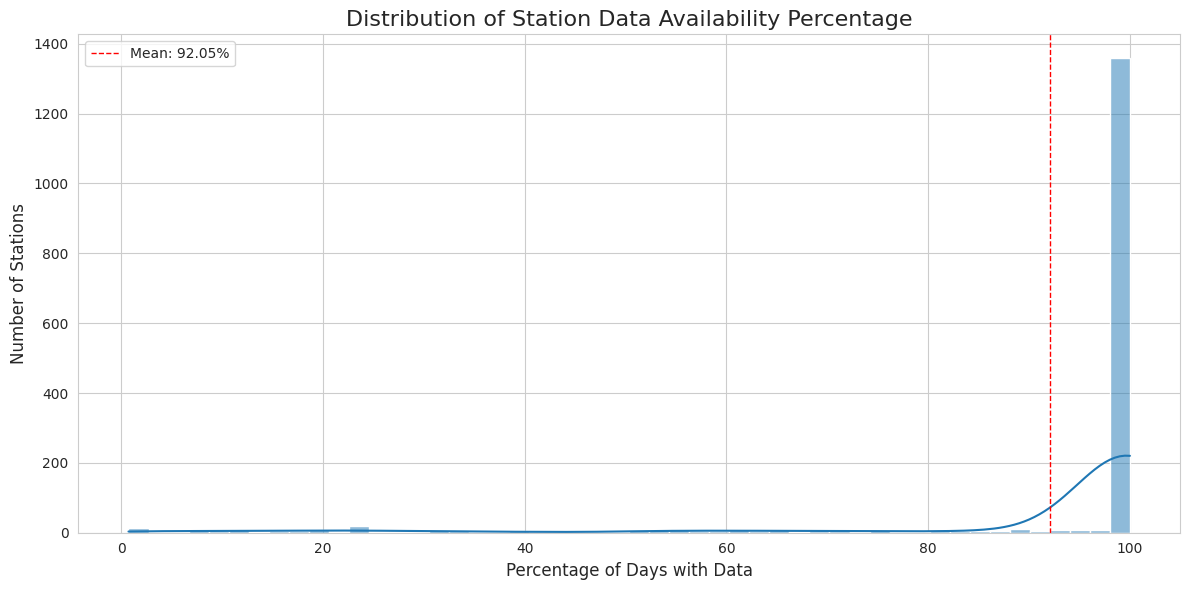

Mean data availability across all stations: 92.05%


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create a histogram of the 'percentage_found' column
plt.figure(figsize=(12, 6))
sns.histplot(availability_df_sorted['percentage_found'], bins=50, kde=True)

# Add titles and labels
plt.title('Distribution of Station Data Availability Percentage', fontsize=16)
plt.xlabel('Percentage of Days with Data', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)

# Add a vertical line for the mean availability
mean_availability = availability_df_sorted['percentage_found'].mean()
plt.axvline(mean_availability, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_availability:.2f}%')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

print(f"Mean data availability across all stations: {mean_availability:.2f}%")

In [10]:
# Filter the DataFrame to include only stations with a percentage found over 90%
stations_over_90_percent = availability_df_sorted[availability_df_sorted['percentage_found'] > 90]

# Get the count of these stations
num_stations_over_90_percent = len(stations_over_90_percent)

print(f"✅ There are {num_stations_over_90_percent} stations with a data availability percentage over 90%.")

# Optionally, display the list of these stations
# print("\nList of stations with over 90% availability:")
# display(stations_over_90_percent)

✅ There are 1389 stations with a data availability percentage over 90%.


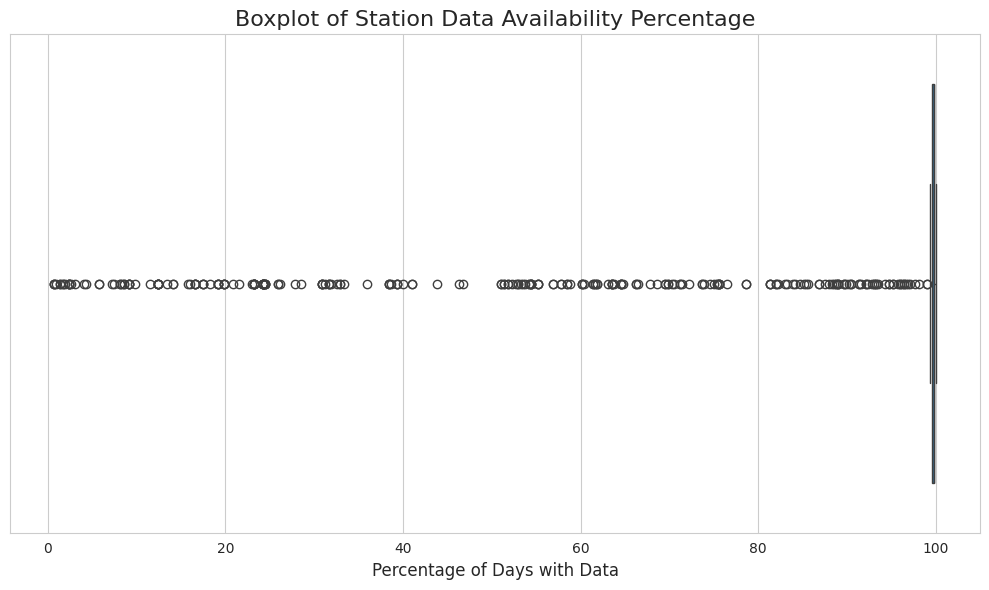


Descriptive statistics for Data Availability Percentage:
count    1607.000000
mean       92.050964
std        21.608496
min         0.719424
25%        99.520384
50%        99.760192
75%        99.760192
max       100.000000
Name: percentage_found, dtype: float64


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create a boxplot of the 'percentage_found' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=availability_df_sorted['percentage_found'])

# Add titles and labels
plt.title('Boxplot of Station Data Availability Percentage', fontsize=16)
plt.xlabel('Percentage of Days with Data', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Optionally, display descriptive statistics
print("\nDescriptive statistics for Data Availability Percentage:")
print(availability_df_sorted['percentage_found'].describe())

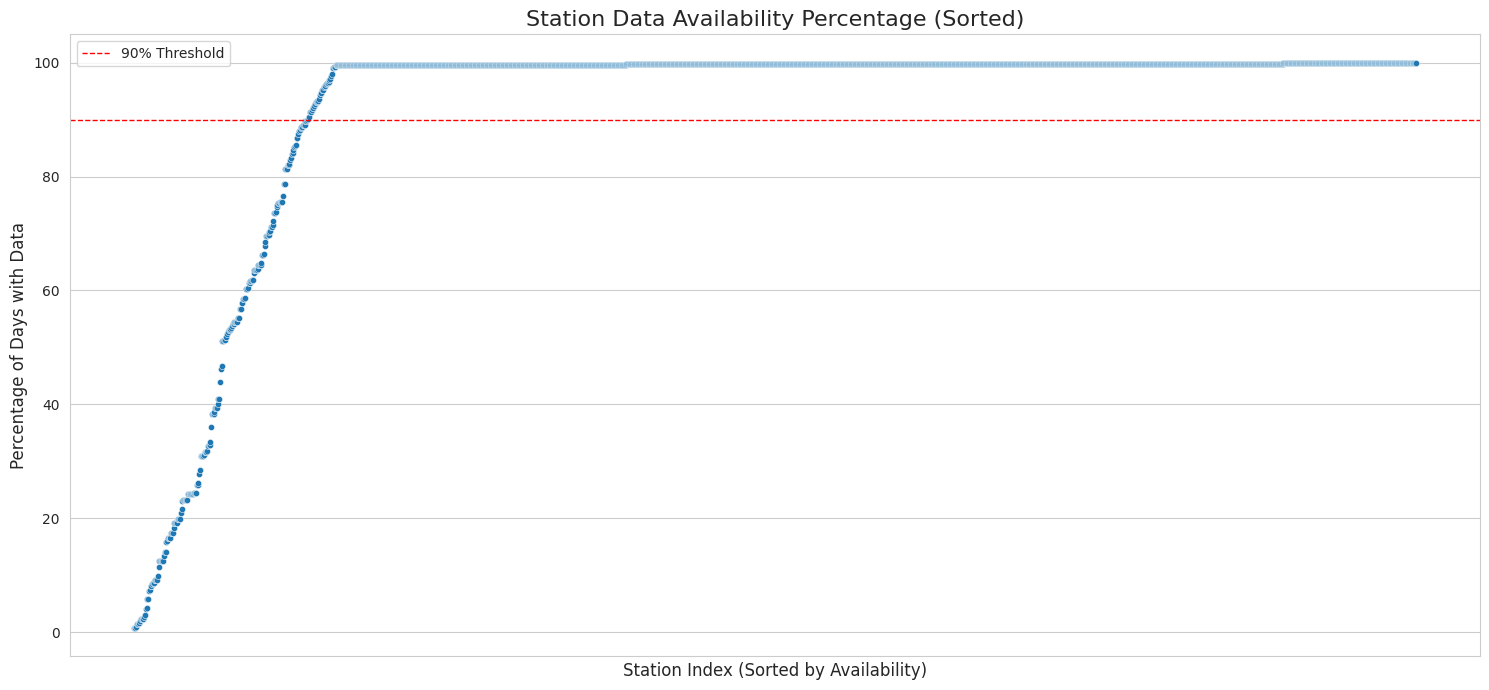

Scatter plot of station data availability percentages.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create a scatter plot with percentages on the y-axis
plt.figure(figsize=(15, 7))
sns.scatterplot(x=availability_df_sorted.index, y=availability_df_sorted['percentage_found'], s=20) # s controls dot size

# Add titles and labels
plt.title('Station Data Availability Percentage (Sorted)', fontsize=16)
plt.xlabel('Station Index (Sorted by Availability)', fontsize=12)
plt.ylabel('Percentage of Days with Data', fontsize=12)

# Improve readability for a large number of points
# You might need to adjust this depending on how many stations you have
plt.xticks([]) # Hide x-axis ticks if too many

# Add a horizontal line at 90% for reference
plt.axhline(90, color='red', linestyle='dashed', linewidth=1, label='90% Threshold')
plt.legend()


# Show the plot
plt.tight_layout()
plt.show()

print("Scatter plot of station data availability percentages.")

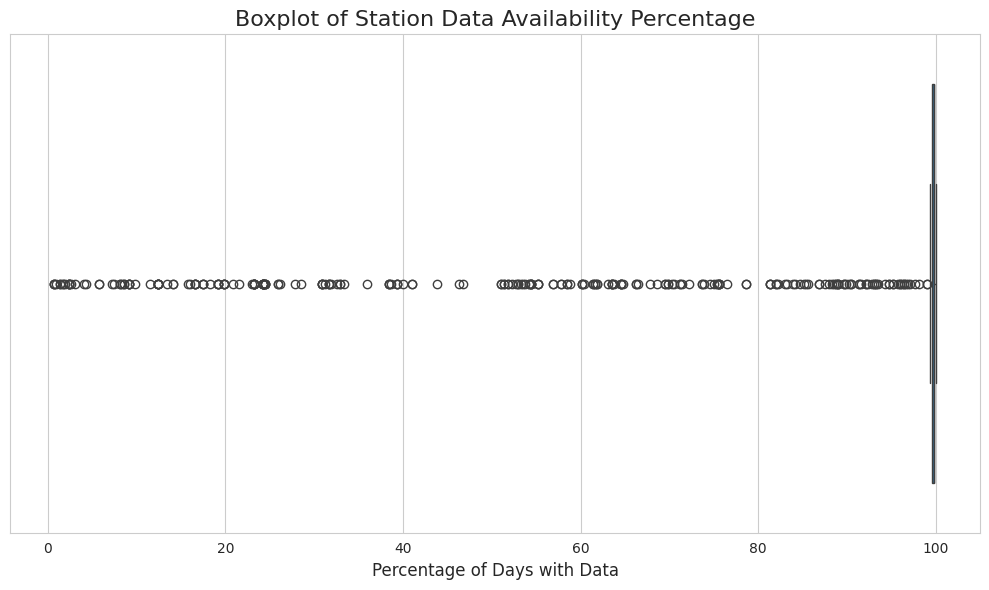


Descriptive statistics for Data Availability Percentage:
count    1607.000000
mean       92.050964
std        21.608496
min         0.719424
25%        99.520384
50%        99.760192
75%        99.760192
max       100.000000
Name: percentage_found, dtype: float64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create a boxplot of the 'percentage_found' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=availability_df_sorted['percentage_found'])

# Add titles and labels
plt.title('Boxplot of Station Data Availability Percentage', fontsize=16)
plt.xlabel('Percentage of Days with Data', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Optionally, display descriptive statistics
print("\nDescriptive statistics for Data Availability Percentage:")
print(availability_df_sorted['percentage_found'].describe())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


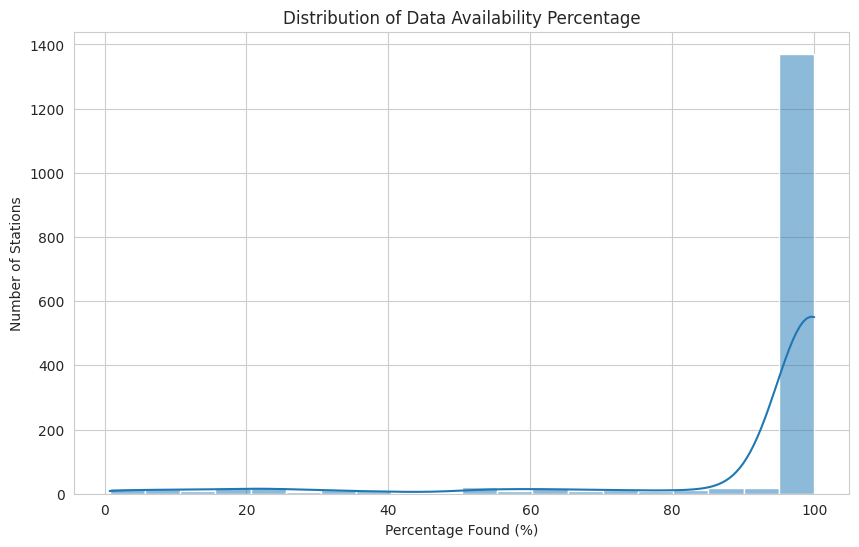

In [3]:
# 1. Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 2. Mount Google Drive
# This will prompt you for authorization.
drive.mount('/content/drive')

# 3. Define the path to your file in Google Drive
# Note: I've renamed the variable to FILE_PATH for clarity
FILE_PATH = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/station_availability_report.csv'

# 4. Load the DataFrame from the CSV file
# The 'index_col' is set based on your initial DataFrame description.
availability_df_sorted = pd.read_csv(FILE_PATH, index_col='Station ID (sno)')

# 5. Generate the plot
# Set the visual style of the plot
sns.set_style("whitegrid")

# Create the plot figure
plt.figure(figsize=(10, 6))

# Generate the histogram with a kernel density estimate (KDE) line
sns.histplot(data=availability_df_sorted, x='percentage_found', bins=20, kde=True)

# Add titles and labels for clarity
plt.title('Distribution of Data Availability Percentage')
plt.xlabel('Percentage Found (%)')
plt.ylabel('Number of Stations')

# Display the plot
plt.show()

# To save the plot to a file in your Google Drive, you could use:
# plt.savefig('/content/drive/MyDrive/Youbike_Master_Project/percentage_distribution.png')

In [4]:
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
# The report file you want to filter
report_filename = 'station_availability_report.csv'
# The new file that will store the filtered list
filtered_report_filename = 'station_availability_report_filtered.csv'

report_path = os.path.join(CLEAN_DATA_DIR, report_filename)
filtered_report_path = os.path.join(CLEAN_DATA_DIR, filtered_report_filename)

# --- 2. Load, Filter, and Save the Report ---
print(f"\nReading your station report from: {report_path}")
try:
    # Load the entire report file (it's small)
    report_df = pd.read_csv(report_path)
    print(f"✓ Report loaded successfully with {len(report_df)} total stations.")

    # Define your reliability threshold
    availability_threshold = 95.0 # as a percentage

    # **THE CORE STEP: Filter the DataFrame**
    # This keeps only the rows where 'percentage_found' is 95 or greater
    filtered_report_df = report_df[report_df['percentage_found'] >= availability_threshold].copy()

    # Save the new, filtered DataFrame to a new CSV file
    filtered_report_df.to_csv(filtered_report_path, index=False, encoding='utf-8-sig')

    print(f"\n--- Filtering Complete ---")
    print(f"✅ Kept {len(filtered_report_df)} stations with availability >= {availability_threshold}%.")
    print(f"✅ Filtered report has been saved to:\n   {filtered_report_path}")

    print("\nHere is a preview of the filtered report (most reliable stations):")
    # Display the top of the filtered list (which are the stations just above 95%)
    print(filtered_report_df.head())

except FileNotFoundError:
    print(f"❌ Error: The report file was not found at '{report_path}'. Please ensure the file exists.")
except Exception as e:
    print(f"An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Reading your station report from: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/station_availability_report.csv
✓ Report loaded successfully with 1607 total stations.

--- Filtering Complete ---
✅ Kept 1371 stations with availability >= 95.0%.
✅ Filtered report has been saved to:
   /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/station_availability_report_filtered.csv

Here is a preview of the filtered report (most reliable stations):
     Station ID (sno)  found_days  not_found_days  percentage_found
236         500111085         397              20         95.203837
237         500108165         397              20         95.203837
238         500103029         399              18         95.683453
239         500106075         400              17         9

In [9]:
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
# The report file you want to filter
report_filename = 'station_availability_report.csv'
# The new file that will store the filtered list
filtered_report_filename = 'station_availability_report_filtered99.csv'

report_path = os.path.join(CLEAN_DATA_DIR, report_filename)
filtered_report_path = os.path.join(CLEAN_DATA_DIR, filtered_report_filename)

# --- 2. Load, Filter, and Save the Report ---
print(f"\nReading your station report from: {report_path}")
try:
    # Load the entire report file (it's small)
    report_df = pd.read_csv(report_path)
    print(f"✓ Report loaded successfully with {len(report_df)} total stations.")

    # Define your reliability threshold
    availability_threshold = 99.0 # as a percentage

    # **THE CORE STEP: Filter the DataFrame**
    # This keeps only the rows where 'percentage_found' is 95 or greater
    filtered_report_df = report_df[report_df['percentage_found'] >= availability_threshold].copy()

    # Save the new, filtered DataFrame to a new CSV file
    filtered_report_df.to_csv(filtered_report_path, index=False, encoding='utf-8-sig')

    print(f"\n--- Filtering Complete ---")
    print(f"✅ Kept {len(filtered_report_df)} stations with availability >= {availability_threshold}%.")
    print(f"✅ Filtered report has been saved to:\n   {filtered_report_path}")

    print("\nHere is a preview of the filtered report (most reliable stations):")
    # Display the top of the filtered list (which are the stations just above 95%)
    print(filtered_report_df.head())

except FileNotFoundError:
    print(f"❌ Error: The report file was not found at '{report_path}'. Please ensure the file exists.")
except Exception as e:
    print(f"An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Reading your station report from: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/station_availability_report.csv
✓ Report loaded successfully with 1607 total stations.

--- Filtering Complete ---
✅ Kept 1358 stations with availability >= 99.0%.
✅ Filtered report has been saved to:
   /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/station_availability_report_filtered99.csv

Here is a preview of the filtered report (most reliable stations):
     Station ID (sno)  found_days  not_found_days  percentage_found
249         500108069         413               4         99.040767
250         500107011         413               4         99.040767
251         500108097         414               3         99.280576
252         500104118         414               3        

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


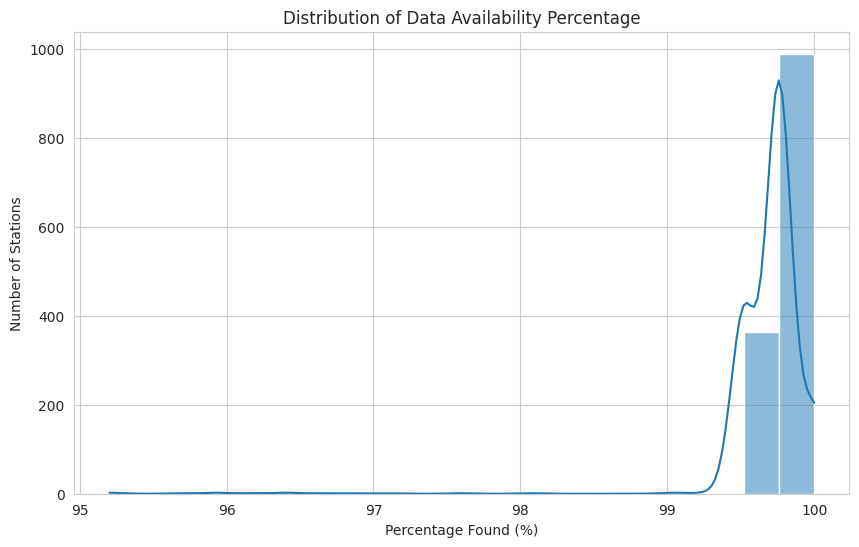

count    1371.000000
mean       99.692150
std         0.363666
min        95.203837
25%        99.520384
50%        99.760192
75%        99.760192
max       100.000000
Name: percentage_found, dtype: float64


In [8]:
# 1. Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 2. Mount Google Drive
# This will prompt you for authorization.
drive.mount('/content/drive')

# 3. Define the path to your file in Google Drive
# Note: I've renamed the variable to FILE_PATH for clarity
FILE_PATH = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/station_availability_report_filtered.csv'

# 4. Load the DataFrame from the CSV file
# The 'index_col' is set based on your initial DataFrame description.
availability_df_sorted = pd.read_csv(FILE_PATH, index_col='Station ID (sno)')

# 5. Generate the plot
# Set the visual style of the plot
sns.set_style("whitegrid")

# Create the plot figure
plt.figure(figsize=(10, 6))

# Generate the histogram with a kernel density estimate (KDE) line
sns.histplot(data=availability_df_sorted, x='percentage_found', bins=20, kde=True)

# Add titles and labels for clarity
plt.title('Distribution of Data Availability Percentage')
plt.xlabel('Percentage Found (%)')
plt.ylabel('Number of Stations')

# Display the plot
plt.show()

# To save the plot to a file in your Google Drive, you could use:
# plt.savefig('/content/drive/MyDrive/Youbike_Master_Project/percentage_distribution.png')
print(availability_df_sorted['percentage_found'].describe())

In [10]:
import pandas as pd
import os
from google.colab import drive

# --- 1. Setup Paths and Mount Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/'
# The report file you want to filter
report_filename = 'station_availability_report.csv'
# The new file that will store the list of discarded stations
discarded_report_filename = 'discarded_stations_report.csv'

report_path = os.path.join(CLEAN_DATA_DIR, report_filename)
discarded_report_path = os.path.join(CLEAN_DATA_DIR, discarded_report_filename)

# --- 2. Load Report and Isolate Discarded Stations ---
print(f"\nReading your station report from: {report_path}")
try:
    # Load the entire report file
    report_df = pd.read_csv(report_path)
    print(f"✓ Report loaded successfully with {len(report_df)} total stations.")

    # Define the reliability threshold
    availability_threshold = 99.0 # as a percentage

    # **THE CORE STEP: Invert the filter to find the discarded stations**
    # This keeps only the rows where 'percentage_found' is LESS THAN 99.0
    discarded_stations_df = report_df[report_df['percentage_found'] < availability_threshold].copy()

    # Sort by percentage to see the worst offenders first
    discarded_stations_df = discarded_stations_df.sort_values(by='percentage_found', ascending=True)

    # Save the new DataFrame of discarded stations to a new CSV file
    discarded_stations_df.to_csv(discarded_report_path, index=False, encoding='utf-8-sig')

    print(f"\n--- Filtering Complete ---")
    print(f"✅ Found {len(discarded_stations_df)} stations with availability < {availability_threshold}%.")
    print(f"✅ List of discarded stations has been saved to:\n   {discarded_report_path}")

    print("\nHere is a preview of the discarded stations (starting with the least reliable):")
    print(discarded_stations_df.head(10).to_string())

except FileNotFoundError:
    print(f"❌ Error: The report file was not found at '{report_path}'. Please ensure the file exists.")
except Exception as e:
    print(f"An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Reading your station report from: /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/station_availability_report.csv
✓ Report loaded successfully with 1607 total stations.

--- Filtering Complete ---
✅ Found 249 stations with availability < 99.0%.
✅ List of discarded stations has been saved to:
   /content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_clean/discarded_stations_report.csv

Here is a preview of the discarded stations (starting with the least reliable):
   Station ID (sno)  found_days  not_found_days  percentage_found
0         500113093           3             414          0.719424
1         500110100           3             414          0.719424
2         500107188           3             414          0.719424
3         500107189           4             413        

In [ ]:
import pandas as pd
import os
from tqdm.auto import tqdm
from google.colab import drive
import shutil

# --- 1. Configuration & Setup ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast'
CLEAN_DATA_DIR = os.path.join(BASE_DIR, 'data_clean/')

# --- Input Files ---
INPUT_PATH = os.path.join(CLEAN_DATA_DIR, 'ubike_consolidated_data_no_sna.csv')
REPORT_PATH = os.path.join(CLEAN_DATA_DIR, 'station_availability_report.csv')

# --- Intermediate and Final Output Files (as CSV) ---
TEMP_FILTERED_PATH = os.path.join(CLEAN_DATA_DIR, 'temp_filtered_data.csv')
FINAL_OUTPUT_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_final_scaffolded_data.csv')

try:
    # --- Step 1: Get the List of Reliable Stations ---
    print(f"\n--- Stage 1 of 4: Loading list of reliable stations ---")
    report_df = pd.read_csv(REPORT_PATH)

    report_df.rename(columns={'Station ID (sno)': 'sno', 'percentage_found': 'active_rate'}, inplace=True)

    availability_threshold = 99.0
    good_stations = report_df[report_df['active_rate'] >= availability_threshold]
    good_sno_list = set(good_stations['sno'].astype(str))
    print(f"✓ Identified {len(good_sno_list)} stations with >= {availability_threshold}% availability.")

    # --- Step 2: Filter the Main Dataset in Chunks ---
    print(f"\n--- Stage 2 of 4: Filtering for reliable stations ---")
    chunk_iterator = pd.read_csv(INPUT_PATH, chunksize=6000000, low_memory=False, parse_dates=['mday'])

    global_min_date, global_max_date = None, None
    is_first_chunk = True

    for chunk in tqdm(chunk_iterator, desc="Filtering chunks"):
        chunk['sno'] = chunk['sno'].astype(str)
        filtered_chunk = chunk[chunk['sno'].isin(good_sno_list)].copy()

        if not filtered_chunk.empty:
            if global_min_date is None or filtered_chunk['mday'].min() < global_min_date: global_min_date = filtered_chunk['mday'].min()
            if global_max_date is None or filtered_chunk['mday'].max() > global_max_date: global_max_date = filtered_chunk['mday'].max()

            # Save the filtered chunk to a temporary CSV file
            if is_first_chunk:
                filtered_chunk.to_csv(TEMP_FILTERED_PATH, mode='w', index=False, header=True)
                is_first_chunk = False
            else:
                filtered_chunk.to_csv(TEMP_FILTERED_PATH, mode='a', index=False, header=False)

    print("✓ Filtering complete.")

    # --- Step 3: Create the Scaffold and Merge ---
    print(f"\n--- Stage 3 of 4: Building time-series scaffold ---")
    # Read the temporary CSV file
    filtered_df = pd.read_csv(TEMP_FILTERED_PATH, parse_dates=['mday'])

    date_range = pd.date_range(start=global_min_date, end=global_max_date, freq='10min')
    scaffold_index = pd.MultiIndex.from_product([list(good_sno_list), date_range], names=['sno', 'mday'])

    filtered_df.set_index(['sno', 'mday'], inplace=True)
    scaffolded_df = filtered_df.reindex(scaffold_index)

    # --- Step 4: Feature Engineering and Saving Final CSV ---
    print("\n--- Stage 4 of 4: Engineering features and saving final file ---")

    scaffolded_df['act'] = scaffolded_df['act'].fillna(0).astype(int)

    static_cols = ['total', 'lat', 'lng', 'sareaen', 'snaen']
    scaffolded_df[static_cols] = scaffolded_df.groupby(level='sno')[static_cols].ffill().bfill()

    time_varying_cols = ['available_rent_bikes', 'available_return_bikes']
    scaffolded_df[time_varying_cols] = scaffolded_df[time_varying_cols].fillna(-1)

    final_df = scaffolded_df.reset_index()

    # Save the final, analysis-ready dataset to a CSV file
    final_df.to_csv(FINAL_OUTPUT_PATH, index=False, encoding='utf-8-sig')

    print(f"\n✅ Success! Your final, scaffolded dataset has been saved to:\n{FINAL_OUTPUT_PATH}")

    # --- Cleanup ---
    os.remove(TEMP_FILTERED_PATH)
    print("✓ Temporary file has been removed.")

except Exception as e:
    print(f"\n❌ An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Stage 1 of 4: Loading list of reliable stations ---
✓ Identified 1358 stations with >= 99.0% availability.

--- Stage 2 of 4: Filtering for reliable stations ---


Filtering chunks: 0it [00:00, ?it/s]

✓ Filtering complete.

--- Stage 3 of 4: Building time-series scaffold ---


In [ ]:
import pandas as pd
import os
from tqdm.auto import tqdm
from google.colab import drive
import shutil

# --- 1. Configuration & Setup ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast'
CLEAN_DATA_DIR = os.path.join(BASE_DIR, 'data_clean/')

# --- Input File (The one created by the script above) ---
FILTERED_INPUT_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_data_filtered_reliable.csv')

# --- Final Output File ---
FINAL_OUTPUT_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_final_scaffolded_data.csv')

try:
    # --- Step 1: Load Filtered Data and Determine Full Date Range ---
    print(f"\n--- Stage 1 of 3: Loading filtered data to determine scope ---")
    # We read the file once to get the station list and date range
    temp_df = pd.read_csv(FILTERED_INPUT_PATH, usecols=['sno', 'mday'], parse_dates=['mday'])
    good_sno_list = sorted(list(temp_df['sno'].astype(str).unique()))
    global_min_date = temp_df['mday'].min()
    global_max_date = temp_df['mday'].max()
    del temp_df # Free up memory
    print(f"✓ Scope determined for {len(good_sno_list)} stations from {global_min_date} to {global_max_date}.")

    # --- Step 2: Create Scaffold and Merge in Batches to Save Memory ---
    print(f"\n--- Stage 2 of 3: Scaffolding and processing in station batches ---")

    # Load the entire filtered dataset. It should be smaller and fit in RAM.
    filtered_df = pd.read_csv(FILTERED_INPUT_PATH, parse_dates=['mday'])
    filtered_df['sno'] = filtered_df['sno'].astype(str)
    filtered_df.set_index(['sno', 'mday'], inplace=True)

    station_batch_size = 100 # Process 100 stations at a time to keep memory usage low
    num_station_batches = int(np.ceil(len(good_sno_list) / station_batch_size))

    is_first_batch_to_save = True

    for i in tqdm(range(num_station_batches), desc="Processing station batches"):
        start_index = i * station_batch_size
        end_index = start_index + station_batch_size
        station_batch = good_sno_list[start_index:end_index]

        # Create a scaffold for this batch of stations
        date_range = pd.date_range(start=global_min_date, end=global_max_date, freq='10min')
        scaffold_index = pd.MultiIndex.from_product([station_batch, date_range], names=['sno', 'mday'])

        # Select the data for the current batch
        batch_data = filtered_df[filtered_df.index.get_level_values('sno').isin(station_batch)]

        # Reindex to apply the scaffold
        scaffolded_batch = batch_data.reindex(scaffold_index)

        # --- Step 3: Feature Engineering for the Batch ---
        scaffolded_batch['act'] = scaffolded_batch['act'].fillna(0).astype(int)

        static_cols = ['total', 'lat', 'lng', 'sareaen', 'snaen']
        scaffolded_batch[static_cols] = scaffolded_batch.groupby(level='sno')[static_cols].ffill().bfill()

        time_varying_cols = ['available_rent_bikes', 'available_return_bikes']
        scaffolded_batch[time_varying_cols] = scaffolded_batch[time_varying_cols].fillna(-1)

        final_batch_df = scaffolded_batch.reset_index()

        # Save the processed batch to the final CSV file
        if is_first_batch_to_save:
            final_batch_df.to_csv(FINAL_OUTPUT_PATH, mode='w', index=False, header=True)
            is_first_batch_to_save = False
        else:
            final_batch_df.to_csv(FINAL_OUTPUT_PATH, mode='a', index=False, header=False)

    print(f"\n✅ Success! Your final, scaffolded dataset has been saved to:\n{FINAL_OUTPUT_PATH}")

except Exception as e:
    print(f"\n❌ An error occurred: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Stage 1 of 3: Loading filtered data to determine scope ---
✓ Scope determined for 1358 stations from 2024-05-03 18:50:00 to 2025-06-23 00:00:00.

--- Stage 2 of 3: Scaffolding and processing in station batches ---


In [1]:
import pandas as pd
import os
from tqdm.auto import tqdm
from google.colab import drive
import shutil
import zipfile

# --- 1. Configuration & Setup ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast'
CLEAN_DATA_DIR = os.path.join(BASE_DIR, 'data_compressed/')

# --- Define File Paths ---
# Source file on Google Drive
INPUT_ZIP_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_data_filtered_reliable.csv.zip')

# Final output file on Google Drive
OUTPUT_ZIP_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_data_filtered_reliable.parquet.zip')

# Temporary local paths on the Colab machine
LOCAL_CSV_ZIP_PATH = '/content/source.zip'
LOCAL_EXTRACT_DIR = '/content/extracted_csv/'
LOCAL_PARQUET_DIR = '/content/temp_parquet/'
LOCAL_PARQUET_ZIP_PATH = '/content/final.zip'

try:
    # --- Step 2: Copy and Unzip the Source CSV ---
    print(f"\n--- Copying {os.path.basename(INPUT_ZIP_PATH)} to local disk ---")
    shutil.copy(INPUT_ZIP_PATH, LOCAL_CSV_ZIP_PATH)

    print("Unzipping CSV file...")
    os.makedirs(LOCAL_EXTRACT_DIR, exist_ok=True)
    with zipfile.ZipFile(LOCAL_CSV_ZIP_PATH, 'r') as zip_ref:
        unzipped_csv_name = zip_ref.namelist()[0]
        zip_ref.extractall(LOCAL_EXTRACT_DIR)

    LOCAL_CSV_PATH = os.path.join(LOCAL_EXTRACT_DIR, unzipped_csv_name)
    print(f"✓ CSV is ready at: {LOCAL_CSV_PATH}")

    # --- Step 3: Convert the Local CSV to a Local Parquet Dataset ---
    print("\n--- Converting CSV to Parquet dataset ---")
    os.makedirs(LOCAL_PARQUET_DIR, exist_ok=True)

    # Read the CSV in chunks and write each chunk as a part of the Parquet dataset
    chunk_iterator = pd.read_csv(LOCAL_CSV_PATH, chunksize=2000000, low_memory=False)
    for i, chunk in enumerate(tqdm(chunk_iterator, desc="Converting chunks")):
        chunk.to_parquet(os.path.join(LOCAL_PARQUET_DIR, f'part-{i}.parquet'), engine='pyarrow')

    print("✓ Conversion to Parquet format complete.")

    # --- Step 4: Zip the New Parquet Directory ---
    print("\n--- Zipping the new Parquet directory ---")
    # The format is 'zip', the root directory to zip is LOCAL_PARQUET_DIR
    shutil.make_archive(
        base_name='/content/final', # name of the output zip file without extension
        format='zip',
        root_dir=LOCAL_PARQUET_DIR
    )
    print("✓ Parquet directory zipped successfully.")

    # --- Step 5: Copy the Final Zip File back to Google Drive ---
    print(f"\n--- Copying final zip file to Google Drive ---")
    shutil.copy(LOCAL_PARQUET_ZIP_PATH, OUTPUT_ZIP_PATH)

    print(f"\n✅ Success! Your new, efficient Parquet zip file is saved at:\n{OUTPUT_ZIP_PATH}")

except FileNotFoundError:
    print(f"❌ Error: Make sure the source file exists at '{INPUT_ZIP_PATH}'")
except Exception as e:
    print(f"\n❌ An error occurred: {e}")
finally:
    # --- Cleanup: Remove all temporary local files and directories ---
    if os.path.exists(LOCAL_CSV_ZIP_PATH): os.remove(LOCAL_CSV_ZIP_PATH)
    if os.path.exists(LOCAL_EXTRACT_DIR): shutil.rmtree(LOCAL_EXTRACT_DIR)
    if os.path.exists(LOCAL_PARQUET_DIR): shutil.rmtree(LOCAL_PARQUET_DIR)
    if os.path.exists(LOCAL_PARQUET_ZIP_PATH): os.remove(LOCAL_PARQUET_ZIP_PATH)
    print("\n✓ Cleaned up all temporary files from the Colab disk.")

Connecting to Google Drive...
Mounted at /content/drive

--- Copying youbike_data_filtered_reliable.csv.zip to local disk ---
Unzipping CSV file...
✓ CSV is ready at: /content/extracted_csv/youbike_data_filtered_reliable.csv

--- Converting CSV to Parquet dataset ---


Converting chunks: 0it [00:00, ?it/s]

✓ Conversion to Parquet format complete.

--- Zipping the new Parquet directory ---
✓ Parquet directory zipped successfully.

--- Copying final zip file to Google Drive ---

✅ Success! Your new, efficient Parquet zip file is saved at:
/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_compressed/youbike_data_filtered_reliable.parquet.zip

✓ Cleaned up all temporary files from the Colab disk.


In [5]:
import pandas as pd
import os
import shutil
import zipfile
from google.colab import drive

# --- 1. Configuration & Setup ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast'
CLEAN_DATA_DIR = os.path.join(BASE_DIR, 'data_compressed/')
LOCAL_DATA_DIR = '/content/data/'

# --- Input File ---
# The final zipped Parquet file you want to inspect
ZIP_FILE_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_data_filtered_reliable.parquet.zip')

try:
    # --- 2. Copy and Unzip Parquet Data to Local Disk ---
    print(f"\n--- Copying {os.path.basename(ZIP_FILE_PATH)} to local disk ---")
    os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

    local_zip_path = '/content/data.zip'
    shutil.copy(ZIP_FILE_PATH, local_zip_path)

    print("Unzipping Parquet dataset...")
    # Get the name of the directory inside the zip to read from it later
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        # Assumes the first entry reveals the directory name
        unzipped_dir_name = zip_ref.namelist()[0].split('/')[0]
        zip_ref.extractall(LOCAL_DATA_DIR)

    LOCAL_PARQUET_PATH = os.path.join(LOCAL_DATA_DIR, unzipped_dir_name)
    print(f"✓ Data is ready on the local disk at: {LOCAL_PARQUET_PATH}")

    # --- 3. Load the Entire Parquet Dataset into a DataFrame ---
    print("\n--- Loading the full dataset into memory for inspection ---")
    # Reading a directory of parquet files is the standard way
    final_df = pd.read_parquet(LOCAL_PARQUET_PATH)

    # --- 4. Display Full Verification Report ---
    print("\n\n--- ✅ Full File Verification Report ---")

    print(f"\n**1. Total Rows:**")
    print(f"   The entire dataset contains {len(final_df):,} rows.")

    print("\n**2. DataFrame Info (Columns, Data Types, Memory Usage):**")
    final_df.info(verbose=True)

    print("\n**3. Data Preview (First 10 rows of the entire file):**")
    print(final_df.head(10).to_string())

    print("\n**4. Data Preview (Last 10 rows of the entire file):**")
    print(final_df.tail(10).to_string())

    print("\n--- Verification of the entire file is complete ---")

except FileNotFoundError:
    print(f"❌ Error: The file was not found at '{ZIP_FILE_PATH}'. Please ensure it exists.")
except Exception as e:
    print(f"\n❌ An error occurred: {e}")
finally:
    # --- Cleanup ---
    if os.path.exists(local_zip_path): os.remove(local_zip_path)
    if os.path.exists(LOCAL_DATA_DIR): shutil.rmtree(LOCAL_DATA_DIR)
    print("\n✓ Cleaned up all temporary files from the Colab disk.")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Copying youbike_data_filtered_reliable.parquet.zip to local disk ---
Unzipping Parquet dataset...
✓ Data is ready on the local disk at: /content/data/part-14.parquet

--- Loading the full dataset into memory for inspection ---


--- ✅ Full File Verification Report ---

**1. Total Rows:**
   The entire dataset contains 2,000,000 rows.

**2. DataFrame Info (Columns, Data Types, Memory Usage):**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 28000000 to 29999999
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   mday                    object 
 1   sno                     int64  
 2   total                   float64
 3   available_rent_bikes    float64
 4   available_return_bikes  float64
 5   lat                     float64
 6   lng                

In [1]:
import pandas as pd
import os
import shutil
import zipfile
from google.colab import drive
from tqdm.auto import tqdm

# --- 1. Configuration & Setup ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast'
CLEAN_DATA_DIR = os.path.join(BASE_DIR, 'data_compressed/')
LOCAL_DATA_DIR = '/content/data/'

# --- Input File ---
ZIP_FILE_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_data_filtered_reliable.parquet.zip')

try:
    # --- 2. Copy and Unzip Parquet Data to Local Disk ---
    print(f"\n--- Copying {os.path.basename(ZIP_FILE_PATH)} to local disk ---")
    os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

    local_zip_path = '/content/data.zip'
    shutil.copy(ZIP_FILE_PATH, local_zip_path)

    print("Unzipping Parquet dataset...")
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DATA_DIR)

    # The local path is the directory where the part-*.parquet files were extracted
    LOCAL_PARQUET_PATH = LOCAL_DATA_DIR
    print(f"✓ Data is ready in the local directory: {LOCAL_PARQUET_PATH}")

    # --- 3. Read the Dataset in Chunks and Aggregate Info ---
    print("\n--- Reading the full dataset in chunks to gather summary info ---")

    # Get the list of all part-*.parquet files
    parquet_parts = sorted([os.path.join(LOCAL_PARQUET_PATH, f) for f in os.listdir(LOCAL_PARQUET_PATH) if f.endswith('.parquet')])

    if not parquet_parts:
        raise FileNotFoundError("No .parquet files found in the unzipped directory.")

    total_rows = 0
    df_head = None
    df_tail = None
    df_dtypes = None
    total_memory_usage_bytes = 0

    # Read the first part to get the head and schema
    first_part_df = pd.read_parquet(parquet_parts[0])
    df_head = first_part_df.head(10)
    df_dtypes = first_part_df.dtypes
    total_rows += len(first_part_df)
    total_memory_usage_bytes += first_part_df.memory_usage(deep=True).sum()

    # Iterate through the rest of the parts
    for part_file in tqdm(parquet_parts[1:], desc="Scanning file parts"):
        chunk_df = pd.read_parquet(part_file)
        total_rows += len(chunk_df)
        total_memory_usage_bytes += chunk_df.memory_usage(deep=True).sum()

    # The tail is the tail of the last part
    df_tail = chunk_df.tail(10)

    # --- 4. Display Full Verification Report ---
    print("\n\n--- ✅ Corrected Full File Verification Report ---")

    print(f"\n**1. Total Rows:**")
    print(f"   The entire dataset contains {total_rows:,} rows.")

    print("\n**2. DataFrame Info (Columns and Data Types):**")
    print(df_dtypes)

    estimated_memory_mb = total_memory_usage_bytes / (1024**2)
    print(f"\n**3. Estimated Full Memory Usage:** ~{estimated_memory_mb:.2f} MB")

    print("\n**4. Data Preview (First 10 rows of the entire file):**")
    print(df_head.to_string())

    print("\n**5. Data Preview (Last 10 rows of the entire file):**")
    print(df_tail.to_string())

    print("\n--- Verification of the entire file is complete ---")

except FileNotFoundError:
    print(f"❌ Error: The file was not found at '{ZIP_FILE_PATH}'. Please ensure it exists.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    # --- Cleanup ---
    if os.path.exists(local_zip_path): os.remove(local_zip_path)
    if os.path.exists(LOCAL_DATA_DIR): shutil.rmtree(LOCAL_DATA_DIR)
    print("\n✓ Cleaned up all temporary files from the Colab disk.")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Copying youbike_data_filtered_reliable.parquet.zip to local disk ---
Unzipping Parquet dataset...
✓ Data is ready in the local directory: /content/data/

--- Reading the full dataset in chunks to gather summary info ---


Scanning file parts:   0%|          | 0/40 [00:00<?, ?it/s]



--- ✅ Corrected Full File Verification Report ---

**1. Total Rows:**
   The entire dataset contains 81,033,479 rows.

**2. DataFrame Info (Columns and Data Types):**
mday                       object
sno                         int64
total                     float64
available_rent_bikes      float64
available_return_bikes    float64
lat                       float64
lng                       float64
sareaen                    object
snaen                      object
dtype: object

**3. Estimated Full Memory Usage:** ~20460.07 MB

**4. Data Preview (First 10 rows of the entire file):**
                  mday        sno  total  available_rent_bikes  available_return_bikes       lat       lng     sareaen                      snaen
0  2024-05-04 00:00:00  500101001   28.0                   6.0                    22.0  25.02605  121.5436  Daan Dist.  MRT Technology Bldg. Sta.
1  2024-05-04 00:10:00  500101001   28.0                   6.0                    22.0  25.02605  121.5436  Daan

In [1]:
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
from google.colab import drive
import shutil
import zipfile

# --- 1. Configuration & Setup ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast'
CLEAN_DATA_DIR = os.path.join(BASE_DIR, 'data_compressed/')
LOCAL_DATA_DIR = '/content/data/'

# --- Input Files ---
ZIP_FILE_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_data_filtered_reliable.parquet.zip')
REPORT_PATH = os.path.join(CLEAN_DATA_DIR, 'station_availability_report.csv')

# --- Final Output File ---
FINAL_OUTPUT_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_final_scaffolded_data.csv')

try:
    # --- 2. Copy and Unzip Parquet Data to Local Disk ---
    print(f"\n--- Copying and unzipping Parquet data to the fast local disk ---")
    os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

    local_zip_path = '/content/data.zip'
    shutil.copy(ZIP_FILE_PATH, local_zip_path)

    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        unzipped_dir_name = os.path.commonpath(zip_ref.namelist())
        zip_ref.extractall(LOCAL_DATA_DIR)

    LOCAL_INPUT_PATH = os.path.join(LOCAL_DATA_DIR, unzipped_dir_name)
    print(f"✓ Data is now ready on the local disk at: {LOCAL_INPUT_PATH}")

    # --- 3. Get Reliable Stations and Global Date Range (Memory-Safe) ---
    print(f"\n--- Stage 1: Loading reliable station list and determining date range ---")
    report_df = pd.read_csv(REPORT_PATH)
    report_df.rename(columns={'Station ID (sno)': 'sno', 'percentage_found': 'active_rate'}, inplace=True, errors='ignore')

    # **THE FIX: Explicitly convert the 'active_rate' column to a numeric type**
    report_df['active_rate'] = pd.to_numeric(report_df['active_rate'], errors='coerce')

    availability_threshold = 99.0
    good_stations = report_df[report_df['active_rate'] >= availability_threshold]
    good_sno_list = sorted(list(good_stations['sno'].astype(str).unique()))
    print(f"✓ Identified {len(good_sno_list)} stations with >= {availability_threshold}% availability.")

    # Scan the file once to get the date range without loading all data
    reader = pd.read_parquet(LOCAL_INPUT_PATH, columns=['mday'])
    global_min_date = pd.to_datetime(reader['mday']).min()
    global_max_date = pd.to_datetime(reader['mday']).max()
    del reader # Free up memory
    print(f"✓ Global date range found: {global_min_date} to {global_max_date}")

    # --- 4. Scaffold, Engineer Features, and Save in Station Batches ---
    print(f"\n--- Stage 2: Scaffolding and saving in memory-safe station batches ---")
    station_batch_size = 50 # Process 50 stations at a time to keep memory low
    num_station_batches = int(np.ceil(len(good_sno_list) / station_batch_size))

    is_first_batch_to_save = True

    for i in tqdm(range(num_station_batches), desc="Processing station batches"):
        start_index = i * station_batch_size
        end_index = start_index + station_batch_size
        station_batch = good_sno_list[start_index:end_index]

        # Load data ONLY for the current batch of stations using a filter
        batch_df = pd.read_parquet(LOCAL_INPUT_PATH, filters=[('sno', 'in', station_batch)])
        batch_df['mday'] = pd.to_datetime(batch_df['mday'])
        batch_df.set_index(['sno', 'mday'], inplace=True)

        # Create a scaffold FOR THIS BATCH ONLY
        date_range = pd.date_range(start=global_min_date, end=global_max_date, freq='10min')
        scaffold_index = pd.MultiIndex.from_product([station_batch, date_range], names=['sno', 'mday'])

        scaffolded_batch = batch_df.reindex(scaffold_index)

        # Feature Engineering for the batch
        scaffolded_batch['act'] = scaffolded_batch['act'].fillna(0).astype(int)
        static_cols = ['total', 'lat', 'lng', 'sareaen', 'snaen']
        scaffolded_batch[static_cols] = scaffolded_batch.groupby(level='sno')[static_cols].ffill().bfill()
        time_varying_cols = ['available_rent_bikes', 'available_return_bikes']
        scaffolded_batch[time_varying_cols] = scaffolded_batch[time_varying_cols].fillna(-1)

        final_batch_df = scaffolded_batch.reset_index()

        # Save the processed batch to the final CSV file
        if is_first_batch_to_save:
            final_batch_df.to_csv(FINAL_OUTPUT_PATH, mode='w', index=False, header=True)
            is_first_batch_to_save = False
        else:
            final_batch_df.to_csv(FINAL_OUTPUT_PATH, mode='a', index=False, header=False)

    print(f"\n✅ Success! Your final, scaffolded dataset has been saved to:\n{FINAL_OUTPUT_PATH}")

except Exception as e:
    print(f"\n❌ An error occurred: {e}")
finally:
    # --- Cleanup ---
    if os.path.exists(LOCAL_DATA_DIR): shutil.rmtree(LOCAL_DATA_DIR)
    if os.path.exists('/content/data.zip'): os.remove('/content/data.zip')
    print("✓ Temporary files have been removed.")

Connecting to Google Drive...
Mounted at /content/drive

--- Copying and unzipping Parquet data to the fast local disk ---
✓ Data is now ready on the local disk at: /content/data/

--- Stage 1: Loading reliable station list and determining date range ---
✓ Identified 1358 stations with >= 99.0% availability.
✓ Global date range found: 2024-05-03 18:50:00 to 2025-06-23 00:00:00

--- Stage 2: Scaffolding and saving in memory-safe station batches ---


Processing station batches:   0%|          | 0/28 [00:00<?, ?it/s]


❌ An error occurred: Function 'greater_equal' has no kernel matching input types (string, int64)
✓ Temporary files have been removed.


In [2]:
import pandas as pd
import os
from google.colab import drive

print("Connecting to Google Drive...")
drive.mount('/content/drive')

CLEAN_DATA_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast/data_compressed/'
REPORT_PATH = os.path.join(CLEAN_DATA_DIR, 'station_availability_report.csv')

print(f"\n--- Debugging the Report File ---")
try:
    report_df = pd.read_csv(REPORT_PATH)
    print("\n1. Data types immediately after loading:")
    print(report_df.dtypes)

    report_df.rename(columns={'Station ID (sno)': 'sno', 'percentage_found': 'active_rate'}, inplace=True, errors='raise')

    # THE FIX: Explicitly convert 'active_rate' to a number
    report_df['active_rate'] = pd.to_numeric(report_df['active_rate'], errors='coerce')

    print("\n2. Data types AFTER converting 'active_rate' to numeric:")
    print(report_df.dtypes)

    availability_threshold = 99.0
    good_stations = report_df[report_df['active_rate'] >= availability_threshold]

    print(f"\n✅ Success! The filter worked correctly.")
    print(f"   Identified {len(good_stations)} stations with >= {availability_threshold}% availability.")

except Exception as e:
    print(f"\n❌ An error occurred during the debug step: {e}")

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Debugging the Report File ---

1. Data types immediately after loading:
Station ID (sno)      int64
found_days            int64
not_found_days        int64
percentage_found    float64
dtype: object

2. Data types AFTER converting 'active_rate' to numeric:
sno                 int64
found_days          int64
not_found_days      int64
active_rate       float64
dtype: object

✅ Success! The filter worked correctly.
   Identified 1358 stations with >= 99.0% availability.


In [1]:
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
from google.colab import drive
import shutil
import zipfile

# --- 1. Configuration & Setup ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Youbike_Master_Project/YouBike_Demand_Forecast'
CLEAN_DATA_DIR = os.path.join(BASE_DIR, 'data_compressed/')
LOCAL_DATA_DIR = '/content/data/'

# --- Input Files ---
ZIP_FILE_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_data_filtered_reliable.parquet.zip')
REPORT_PATH = os.path.join(CLEAN_DATA_DIR, 'station_availability_report.csv')

# --- Final Output File ---
FINAL_OUTPUT_PATH = os.path.join(CLEAN_DATA_DIR, 'youbike_final_scaffolded_data.csv')

try:
    # --- 2. Copy and Unzip Parquet Data to Local Disk ---
    print(f"\n--- Copying and unzipping Parquet data to the fast local disk ---")
    os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

    local_zip_path = '/content/data.zip'
    shutil.copy(ZIP_FILE_PATH, local_zip_path)

    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        unzipped_dir_name = os.path.commonpath(zip_ref.namelist())
        zip_ref.extractall(LOCAL_DATA_DIR)

    LOCAL_INPUT_PATH = os.path.join(LOCAL_DATA_DIR, unzipped_dir_name)
    print(f"✓ Data is now ready on the local disk at: {LOCAL_INPUT_PATH}")

    # --- 3. Get Reliable Stations and Global Date Range ---
    print(f"\n--- Stage 1: Loading reliable station list and determining date range ---")
    report_df = pd.read_csv(REPORT_PATH)
    report_df.rename(columns={'Station ID (sno)': 'sno', 'percentage_found': 'active_rate'}, inplace=True, errors='raise')

    # THE FIX: Explicitly convert the 'active_rate' column to a numeric type
    report_df['active_rate'] = pd.to_numeric(report_df['active_rate'], errors='coerce')

    availability_threshold = 99.0
    good_stations = report_df[report_df['active_rate'] >= availability_threshold]
    good_sno_list = sorted(list(good_stations['sno'].astype(str).unique()))
    print(f"✓ Identified {len(good_sno_list)} stations with >= {availability_threshold}% availability.")

    # Scan the file once to get the date range without loading all data
    reader = pd.read_parquet(LOCAL_INPUT_PATH, columns=['mday'])
    global_min_date = pd.to_datetime(reader['mday']).min()
    global_max_date = pd.to_datetime(reader['mday']).max()
    del reader # Free up memory
    print(f"✓ Global date range found: {global_min_date} to {global_max_date}")

    # --- 4. Scaffold, Engineer Features, and Save in Station Batches ---
    print(f"\n--- Stage 2: Scaffolding and saving in memory-safe station batches ---")
    station_batch_size = 50
    num_station_batches = int(np.ceil(len(good_sno_list) / station_batch_size))
    is_first_batch_to_save = True

    for i in tqdm(range(num_station_batches), desc="Processing station batches"):
        start_index = i * station_batch_size
        end_index = start_index + station_batch_size
        station_batch = good_sno_list[start_index:end_index]

        batch_df = pd.read_parquet(LOCAL_INPUT_PATH, filters=[('sno', 'in', station_batch)])
        batch_df['mday'] = pd.to_datetime(batch_df['mday'])
        batch_df.set_index(['sno', 'mday'], inplace=True)

        date_range = pd.date_range(start=global_min_date, end=global_max_date, freq='10min')
        scaffold_index = pd.MultiIndex.from_product([station_batch, date_range], names=['sno', 'mday'])

        scaffolded_batch = batch_df.reindex(scaffold_index)

        scaffolded_batch['act'] = scaffolded_batch['act'].fillna(0).astype(int)
        static_cols = ['total', 'lat', 'lng', 'sareaen', 'snaen']
        scaffolded_batch[static_cols] = scaffolded_batch.groupby(level='sno')[static_cols].ffill().bfill()
        time_varying_cols = ['available_rent_bikes', 'available_return_bikes']
        scaffolded_batch[time_varying_cols] = scaffolded_batch[time_varying_cols].fillna(-1)

        final_batch_df = scaffolded_batch.reset_index()

        if is_first_batch_to_save:
            final_batch_df.to_csv(FINAL_OUTPUT_PATH, mode='w', index=False, header=True)
            is_first_batch_to_save = False
        else:
            final_batch_df.to_csv(FINAL_OUTPUT_PATH, mode='a', index=False, header=False)

    print(f"\n✅ Success! Your final, scaffolded dataset has been saved to:\n{FINAL_OUTPUT_PATH}")

except Exception as e:
    print(f"\n❌ An error occurred: {e}")
finally:
    # --- Cleanup ---
    if os.path.exists(LOCAL_DATA_DIR): shutil.rmtree(LOCAL_DATA_DIR)
    if os.path.exists('/content/data.zip'): os.remove('/content/data.zip')
    print("✓ Temporary files have been removed.")

Connecting to Google Drive...
Mounted at /content/drive

--- Copying and unzipping Parquet data to the fast local disk ---
✓ Data is now ready on the local disk at: /content/data/

--- Stage 1: Loading reliable station list and determining date range ---
✓ Identified 1358 stations with >= 99.0% availability.
✓ Global date range found: 2024-05-03 18:50:00 to 2025-06-23 00:00:00

--- Stage 2: Scaffolding and saving in memory-safe station batches ---


Processing station batches:   0%|          | 0/28 [00:00<?, ?it/s]


❌ An error occurred: Function 'greater_equal' has no kernel matching input types (string, int64)
✓ Temporary files have been removed.
